In [3]:
import json
import uuid
import os
from operator import itemgetter

from elasticsearch import Elasticsearch
from ssl import create_default_context
import pandas as pd
from datetime import datetime
from collections import namedtuple
from pathlib import Path
import glob

import matplotlib.pyplot as plt
import seaborn as sns

from gluonts.mx import Trainer

/home/leonid/miniconda3/lib/python3.8/site-packages/gluonts/json.py:45: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


# Primary analysis of the combined log data
The goal is to combine the existed log data in a single dataset and try to find patterns with autoencoder or forecasting.

## Data preparation

In [4]:
file_pattern = '../data/2021*cluster*'
filenames = glob.glob(file_pattern)
print(filenames)
[f.split('/')[-1].split('.')[1] for f in filenames]
dfs = {f.split('/')[-1].split('.')[2]: pd.read_csv(f) for f in filenames}
print([(k, df.shape, df.columns) for k, df in dfs.items()])

['../data/20210722_172941.cluster.dns.115K.csv', '../data/20210722_172919.cluster.l7.10K.csv', '../data/20210722_172916.cluster.flows.40K.csv']
[('dns', (115211, 9), Index(['start_time', 'end_time', 'client_name_aggr', 'client_namespace',
       'qname', 'latency_count', 'latency_mean', 'latency_max', 'host'],
      dtype='object')), ('l7', (10296, 22), Index(['start_time', 'end_time', 'duration_mean', 'duration_max', 'bytes_in',
       'bytes_out', 'count', 'src_name_aggr', 'src_namespace', 'src_type',
       'dest_service_name', 'dest_service_namespace', 'dest_service_port',
       'dest_name_aggr', 'dest_namespace', 'dest_type', 'method', 'user_agent',
       'url', 'response_code', 'type', 'host'],
      dtype='object')), ('flows', (40773, 36), Index(['start_time', 'end_time', 'source_ip', 'source_name',
       'source_name_aggr', 'source_namespace', 'source_port', 'source_type',
       'source_labels', 'dest_ip', 'dest_name', 'dest_name_aggr',
       'dest_namespace', 'dest_servic

/home/leonid/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (2,9) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


To combine these logs we have to to thiese things:
- The 'start_time' has different formats in logs. We have to convert all of them to a single format. UTC should be taken care of.
- we group records by time buckets. All 'start_time' adjusted to 0 + i*5 times by increasing time. Say, 0 -> 0; 1,2,3,4 -> 5, ...
- iside the time buckets we group records by address fields. The address fields should be selected. Cardinality of the address fields should be taken in account at last for this experiment.

In [46]:
# from datetime import datetime
# from time import time
# # start_time in the end of logs
# dns_start_time = '2021-04-01T23:55:51'
# l7_start_time    = 1617321235
# flows_start_time = 1617298173

# l7_start_time - flows_start_time # 23062 - means L7 in UTC, flows in local. (???) Do we need to add 25200 to flow start_time?

23062

In [56]:
# # start_time in the start of logs
# dns_start_time_str = '2021-03-22T16:28:51.565759887Z'
# dns_start_time = int(datetime.strptime(dns_start_time_str.split('.')[0], '%Y-%m-%dT%H:%M:%S').timestamp())
# l7_start_time    = 1617231868
# flows_start_time = 1614876237

# l7_start_time, dns_start_time, flows_start_time,  l7_start_time-dns_start_time, dns_start_time-flows_start_time, l7_start_time-flows_start_time

(1617231868, 1616455731, 1614876237, 776137, 1579494, 2355631)

In [99]:
# from dateutil.parser import parse

# dns_start_time = int(parse(dns_start_time_str).timestamp())
# dns_start_time
# # parse(dns_start_time_str)

1616430531

In [5]:
from dateutil.parser import parse

dfs['dns']['start_time'] = dfs['dns']['start_time'].apply(lambda x: int(parse(x).timestamp()))
# dfs['dns']['end_time'] = dfs['dns']['end_time'].apply(lambda x: int(parse(dns_start_time_str).timestamp()))

dfs['dns'].head(2)

,start_time,end_time,client_name_aggr,client_namespace,qname,latency_count,latency_mean,latency_max,host
0,1618847084,2021-04-19T15:49:51.52347056Z,alertmanager-calico-node-alertmanager-*,tigera-prometheus,alertmanager-calico-node-alertmanager-0.alertm...,21,687709,3882000,leonid-bz-6grr-kadm-node-0
1,1618847084,2021-04-19T15:49:51.52347056Z,alertmanager-calico-node-alertmanager-*,tigera-prometheus,alertmanager-calico-node-alertmanager-1.alertm...,21,637899,3815000,leonid-bz-6grr-kadm-node-0


In [6]:
def apply_adjust_by_n_minutes(val, minutes=5):
    return val - val%(minutes*60)

def adjust_by_n_minutes(key):
    dfs[key]['start_time'] = dfs[key]['start_time'].apply(apply_adjust_by_n_minutes)
    dfs[key].set_index('start_time', inplace=True)
    print(f'{key}: {dfs[key].shape}, {dfs[key].columns}')
    return

[adjust_by_n_minutes(k) for k in dfs]

dns: (115211, 8), Index(['end_time', 'client_name_aggr', 'client_namespace', 'qname',
       'latency_count', 'latency_mean', 'latency_max', 'host'],
      dtype='object')
l7: (10296, 21), Index(['end_time', 'duration_mean', 'duration_max', 'bytes_in', 'bytes_out',
       'count', 'src_name_aggr', 'src_namespace', 'src_type',
       'dest_service_name', 'dest_service_namespace', 'dest_service_port',
       'dest_name_aggr', 'dest_namespace', 'dest_type', 'method', 'user_agent',
       'url', 'response_code', 'type', 'host'],
      dtype='object')
flows: (40773, 35), Index(['end_time', 'source_ip', 'source_name', 'source_name_aggr',
       'source_namespace', 'source_port', 'source_type', 'source_labels',
       'dest_ip', 'dest_name', 'dest_name_aggr', 'dest_namespace',
       'dest_service_namespace', 'dest_service_name', 'dest_service_port',
       'dest_port', 'dest_type', 'dest_labels', 'proto', 'bytes_in',
       'bytes_out', 'num_flows', 'num_flows_started', 'num_flows_completed'

[None, None, None]

In [7]:
dfs['l7'].head(2)

,end_time,duration_mean,duration_max,bytes_in,bytes_out,count,src_name_aggr,src_namespace,src_type,dest_service_name,...,dest_service_port,dest_name_aggr,dest_namespace,dest_type,method,user_agent,url,response_code,type,host
start_time,,,,,,,,,,,,,,,,,,,,,
1618865400,1618865742,8530266666,15003000000,0,11376130,1410,loadgenerator-6cb7f7fb76-*,default,wep,frontend,...,80,frontend-6f4b9f97bd-*,default,wep,GET,-,frontend/product/66VCHSJNUP,200,-,leonid-bz-6grr-kadm-node-1
1618865400,1618865742,15000000000,15000000000,0,24,1,loadgenerator-6cb7f7fb76-*,default,wep,frontend,...,80,frontend-6f4b9f97bd-*,default,wep,GET,-,frontend/product/2ZYFJ3GM2N,504,-,leonid-bz-6grr-kadm-node-1


In [174]:
## NOTE concat does not work because frames have duplicate index values (several rows with the same 'start_time')

# t = pd.concat(
#     [dfs['flows'], dfs['l7'], dfs['dns']],
#     axis=1,
#     join="outer",
#     ignore_index=False,
#     keys=None, # ['start_time'],
#     levels=None,
#     names=None,
#     verify_integrity=False,
#     copy=False,
# )
# t.shape

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [8]:
[(k, df.shape) for k, df in dfs.items()]

[('dns', (115211, 8)), ('l7', (10296, 21)), ('flows', (40773, 35))]

In [17]:
## should be done only after resampling df to 1 record by 5 min bucket! 

# how = 'inner'
# # print(len(dfs['flows'].columns), len(dfs['l7'].columns))
# # df12 = dfs['flows'].merge(dfs['l7'], on='start_time', how=how, suffixes=('_flows', '_l7')) #.to_csv('../data/flow_and_l7.csv', index=False)
# # # (1465725, 56)
# df12 = dfs['flows'].join(dfs['l7'], how=how, lsuffix='_flows', rsuffix='_l7') #.to_csv('../data/flow_and_l7.csv', index=False)
# print(df12.shape, df12.columns)
# # df = df12.merge(dfs['dns'], on='start_time', how=how, suffixes=('', '_dns')) #.to_csv('../data/flow_and_l7.csv', index=False)
# # print(df.shape, df.columns)


In [16]:
removed_cols = ['@timestamp', 'source_labels', 'dest_labels', 'client_labels', 'end_time']


for log, df in dfs.items():    
    print(log)
    df.drop(columns=removed_cols, inplace=True, errors='ignore')
    df.sort_values(by='start_time', inplace=True)
    df.shape, df.columns

dfs['flows'].columns
## 'outer': ((729208, 77)
## inner: ((0, 77)

dns
l7
flows


Index(['source_ip', 'source_name', 'source_name_aggr', 'source_namespace',
       'source_port', 'source_type', 'dest_ip', 'dest_name', 'dest_name_aggr',
       'dest_namespace', 'dest_service_namespace', 'dest_service_name',
       'dest_service_port', 'dest_port', 'dest_type', 'proto', 'bytes_in',
       'bytes_out', 'num_flows', 'num_flows_started', 'num_flows_completed',
       'packets_in', 'packets_out', 'http_requests_allowed_in',
       'http_requests_denied_in', 'process_name', 'num_process_names',
       'process_id', 'num_process_ids', 'original_source_ips',
       'num_original_source_ips', 'host'],
      dtype='object')

In [114]:
df.set_index('start_time', inplace=True)
df = df.reindex(sorted(df.columns), axis=1)
df.to_csv('../data/flow_and_l7_and_dns.csv', index=False)

In [115]:
df.shape

(729208, 76)

In [122]:
pd.set_option('display.max_rows', 500)

from pandas_summary import DataFrameSummary

dfs = DataFrameSummary(df)
dfs.columns_stats.T.sort_values(by='types').head(80).sort_index()

,counts,uniques,missing,missing_perc,types
method,27935,2,701273,96.17%,bool
action,519628,2,209580,28.74%,bool
src_type,27941,2,701267,96.17%,bool
src_namespace,27941,2,701267,96.17%,bool
reporter,519628,2,209580,28.74%,bool
source_type,519628,2,209580,28.74%,bool
proto,519628,2,209580,28.74%,bool
rcode,202997,2,526211,72.16%,bool
rrsets,202654,2272,526554,72.21%,categorical
dest_type_flows,519628,3,209580,28.74%,categorical


In [ ]:
counts_zero_cols = ['source_port', 'client_ip', 'original_source_ips']
convert_to_numeric_cols = ['latency']


## Conclusions and Design draft

Our 3 logs mostly do not correlate. If we merge all logs we got samples where 3 group of fields correlate only by start_time. Each log has M_to_1 rows_in_time_bucket relations. That means the merging result table gets number of rows as the product ot the numbers of rows each merging table. Say, dns - 10K rows, l7 - 10K rows, flows - 100K rows. The result table - 10K * 10K * 100K rows. Each row has only meaningfull fields from single table.

So, the table merging does not provide us with anything but an inflated dataset.

If each time interval is provided with a single row, merge makes sense. But not for now when each time interval has >10 rows in each table.

So, the problem is, the logs cannot be easily combined into the required format with a single row per a time bucket. Each log can have several rows per each bucket and these rows are not correlated between logs.

What we can do now? Thera are two options, a 'per address' and 'global'. 
1. In the **per address** option we split all rows of a log into several groups by addresses. Each group should have only one row per time bucket. Each group has this format:
   Log_X_Address_XX: `[time_interval, vector]`
   With 10*x source and dest addresses and 10*y addr1_to_addr2 connections (as address groups) we have got not too much dimentions for this concatenated vector.
   We select only the most-frequent addresses. All non-frequestn addresses go to the 'other' addresses with combined vector.
   Each Log_X_Address_XX dataset gets a model which is the sequencial-autoencoder or the time-series forecaster. 
   This option is like the bytes_in model.

2. In the **global** option we do not include addresses in data and use only the aggregated vectors: 
   Log_X: `[time_interval, vector]`. 
   We train a NN for each log as the sequencial-autoencoder or the time-series forecaster. 
   When a model detects the anomaly, we unwind log back to find the records for the anomaly time and select the records with anomalous vectors. 
   
Where `time_interval` can be [start_time, end_time] or just 'start_time' if we have predefined size of the time interval.

Where `address` is one of this format:
   - `point address` for the rows with the actor data. For example: service_namespace+service_name
   - `source_to_dest address` for the rows with the connection data. It is effectively a concatenation of two point addresses. For example: source_namespace+source_name_aggr + dest_namespace+dest_name_aggr

Where `vector` is a multidimentional vector with metrics. For example, [bytes_in, bytes_out, latency_mean, latency_max, packages_in, packages_out, number_of_process_restarts, number_of_connections]



In [1]:
from datetime import datetime, timedelta
import time

t = datetime.utcnow()
time.sleep(1)
(datetime.utcnow() - t).seconds

1

In [17]:
# 
# # Given an array of integers `input` and another  integer `sum`.
# # Return the pairs from input that sums to sum
# # input = [5,3,4,2,1,0,7], sum = 5
# # return = [[2,3],[4,1],[5,0]]

from itertools import combinations

input = [2,2,2,5,3,3,2,7,8,0] #[5,3,4,2,1,0,7]
sum_target = 5

([sorted(c) for c in combinations(input, 2) if sum(c) == sum_target])

[[2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [0, 5], [2, 3], [2, 3]]

In [13]:
# 2021-03-20T16:51:23.644+01:00
datetime.now().isoformat(), datetime.fromisoformat(datetime.now().isoformat()), datetime.fromisoformat('2021-06-07 16:49:04.471477Z')

('2021-06-07T16:49:39.304120',
 datetime.datetime(2021, 6, 7, 16, 49, 39, 304124),
 datetime.datetime(2021, 6, 7, 16, 49, 4, 471477))

In [9]:
datetime.now()

datetime.datetime(2021, 6, 7, 23, 47, 50, 643046)

In [14]:
'2021-06-07 16:49:04.471477Z'.endswith('Z')

True

In [16]:
s = "2021-06-08T15:39:53.191356"
datetime.fromisoformat(s)

datetime.datetime(2021, 6, 8, 15, 39, 53, 191356)

In [18]:
ts = datetime.utcnow()
time.sleep(1)
ts_svc = datetime.utcnow()
(ts_svc - ts).seconds

1

In [19]:
86399 / 60 / 60

23.99972222222222

In [21]:
ts = datetime.utcnow()
rs = {'service': 'anomaly_detection_service', 'utcnow': '2021-06-08T16:53:47.467571'}
print(rs, type(ts))
assert rs['service'] == "anomaly_detection_service"
ts_svc = datetime.fromisoformat(rs['utcnow'])
print(ts_svc, type(ts_svc))
assert abs(ts.seconds - ts_svc.seconds) < 2


{'service': 'anomaly_detection_service', 'utcnow': '2021-06-08T16:53:47.467571'} <class 'datetime.datetime'>
2021-06-08 16:53:47.467571 <class 'datetime.datetime'>


AttributeError: 'datetime.datetime' object has no attribute 'seconds'

In [23]:
ts = datetime.utcnow()
ts.second

24

In [24]:
rs = {'service': 'anomaly_detection_service', 'utcnow': '2021-06-08T16:53:47.467571'}
print(rs, type(ts))
assert rs['service'] == "anomaly_detection_service"
ts_svc = datetime.fromisoformat(rs['utcnow'])
ts_svc

{'service': 'anomaly_detection_service', 'utcnow': '2021-06-08T16:53:47.467571'} <class 'datetime.datetime'>


datetime.datetime(2021, 6, 8, 16, 53, 47, 467571)

In [25]:
ts_svc.second

47

In [30]:
samples = [{'asdf'}]
sample = samples[0] if samples else {}
sample

{'asdf'}

In [38]:
from datetime import timedelta
(datetime.utcnow() - timedelta(days=2)).isoformat()

'2021-06-08T16:05:54.375453'

In [42]:
import pickle

file_name = '../data/temp.model'
with open(file_name, 'wb') as f:
    out = {'model': None, 'aggregators': None}
    pickle.dump(out, f, pickle.HIGHEST_PROTOCOL)
    print(f'    Model sdfsdf saved into {file_name}')

    Model sdfsdf saved into ../data/temp.model


In [43]:
with open(file_name, 'rb') as f:
    out = pickle.load(f)
    print(f'    Model asdfa loaded from {file_name}')
#     return out
out


    Model asdfa loaded from ../data/temp.model


{'model': None, 'aggregators': None}

In [46]:
fields = 'start_time source_name_aggr source_namespace dest_ip dest_port bytes_out dest_namespace dest_service_name bytes_in'.split()

import pandas as pd

file_in  = '../../anomaly_detection_jobs/data/flows.all_fields.manoj.248K.csv'
file_out = '../../anomaly_detection_jobs/data/flows.test_dataset.csv'
df = pd.read_csv (file_in)
df[fields].to_csv(file_out, index=False)

/home/leonid/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (1,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [47]:
datetime.utcnow().isoformat() + 'Z'

'2021-06-10T22:04:03.347606Z'

In [92]:
datetime.utcnow()

datetime.datetime(2021, 6, 15, 17, 1, 7, 716484)

In [58]:
url = 'adasdfs.sdf'
''.join([d for d in url.split('.')[:-1]])

'adasdfs'

In [75]:
import pandas as pd
from collections import defaultdict
import json

def _prepare_url2samples(samples):
    """
    It extracts urls from samples and saves correspondent samples
    as {'url': [sample, ...]}.
    NOTE: the same url can be presented in several samples.
    """

    def filter_qname(s):
        return (
                s.endswith('.local')
                or s.endswith('.internal')
                or s.endswith('.svc')
                or '.' not in s
        )

    def filter_sample(r):
        """
        It returns qname or an empty string if the record filtered out.
        """
        return r['qname'] if (
                r['qtype'] == 'A'
                and r['rcode'] == 'NXDomain'
                and not filter_qname(r['qname'])
        ) else ""

    url2samples = defaultdict(list)
    for s in samples:
        url = filter_sample(s)
        if url:
            url2samples[url].append(s)
    return url2samples

file_in  = '../../anomaly_detection_jobs/data/dga.test_dataset.csv'
samples = pd.read_csv (file_in).to_dict('records')
url2samples = _prepare_url2samples(samples)
len(samples), len(url2samples), list(url2samples.items())[0]
json.dumps(samples[0])
print(json.dumps(samples[0]))

{"start_time": "2021-03-22T16:28:51.565759887Z", "end_time": "2021-03-22T16:34:16.228614279Z", "type": "log", "count": 324, "client_name": "-", "client_name_aggr": "loadgenerator-5d4c9686fd-*", "client_namespace": "default", "client_ip": NaN, "servers": "[{'name': 'coredns-f9fd979d6-npsf7', 'name_aggr': 'coredns-f9fd979d6-*', 'namespace': 'kube-system', 'ip': '192.168.93.36'}, {'name': 'coredns-f9fd979d6-znjgn', 'name_aggr': 'coredns-f9fd979d6-*', 'namespace': 'kube-system', 'ip': '192.168.15.178'}]", "qname": "hiliudmivob.com", "qclass": "IN", "qtype": "A", "rcode": "NXDomain", "rrsets": "[{'name': 'frontend.default.svc.cluster.local', 'class': 'IN', 'type': 'A', 'rdata': ['10.106.193.125']}]", "latency_count": 323, "latency_mean": 751987, "latency_max": 4905000, "host": "leonid-bz-rezf-kadm-node-1", "anomaly": 1}


In [76]:
samples[0]

{'start_time': '2021-03-22T16:28:51.565759887Z',
 'end_time': '2021-03-22T16:34:16.228614279Z',
 'type': 'log',
 'count': 324,
 'client_name': '-',
 'client_name_aggr': 'loadgenerator-5d4c9686fd-*',
 'client_namespace': 'default',
 'client_ip': nan,
 'servers': "[{'name': 'coredns-f9fd979d6-npsf7', 'name_aggr': 'coredns-f9fd979d6-*', 'namespace': 'kube-system', 'ip': '192.168.93.36'}, {'name': 'coredns-f9fd979d6-znjgn', 'name_aggr': 'coredns-f9fd979d6-*', 'namespace': 'kube-system', 'ip': '192.168.15.178'}]",
 'qname': 'hiliudmivob.com',
 'qclass': 'IN',
 'qtype': 'A',
 'rcode': 'NXDomain',
 'rrsets': "[{'name': 'frontend.default.svc.cluster.local', 'class': 'IN', 'type': 'A', 'rdata': ['10.106.193.125']}]",
 'latency_count': 323,
 'latency_mean': 751987,
 'latency_max': 4905000,
 'host': 'leonid-bz-rezf-kadm-node-1',
 'anomaly': 1}

In [84]:
import numpy as np
import math

s = {}
for k, v in samples[0].items():
    s[k] = 0 if v != v else v
s


{'start_time': '2021-03-22T16:28:51.565759887Z',
 'end_time': '2021-03-22T16:34:16.228614279Z',
 'type': 'log',
 'count': 324,
 'client_name': '-',
 'client_name_aggr': 'loadgenerator-5d4c9686fd-*',
 'client_namespace': 'default',
 'client_ip': 0,
 'servers': "[{'name': 'coredns-f9fd979d6-npsf7', 'name_aggr': 'coredns-f9fd979d6-*', 'namespace': 'kube-system', 'ip': '192.168.93.36'}, {'name': 'coredns-f9fd979d6-znjgn', 'name_aggr': 'coredns-f9fd979d6-*', 'namespace': 'kube-system', 'ip': '192.168.15.178'}]",
 'qname': 'hiliudmivob.com',
 'qclass': 'IN',
 'qtype': 'A',
 'rcode': 'NXDomain',
 'rrsets': "[{'name': 'frontend.default.svc.cluster.local', 'class': 'IN', 'type': 'A', 'rdata': ['10.106.193.125']}]",
 'latency_count': 323,
 'latency_mean': 751987,
 'latency_max': 4905000,
 'host': 'leonid-bz-rezf-kadm-node-1',
 'anomaly': 1}

In [66]:
def _baseline_detection(urls):
    """
    returns:: anomalies: a list of URLs that detected as anomalies with an anomaly score.
    An example: [{'url': 'k3hh881t1t1t1.co', 'score': 0.945}, ...]
    It can be an empty list if no URL marked as anomalies.
    """
    if not urls: return []
    anomalies, suspicious_domains = [], []
    for url in urls:
        try:
            url = str(url)
            domain = ''.join([d for d in url.split('.')[:-1]])
            if len(domain) > 6:
                suspicious_domains.append({'url': url, 'domain': domain})
        except:
            print('*****', url)
    anomalies = [
        {
            'url': s_d['url'],
            'score': 0.6, #self._baseline_model.predict_proba(list(self._extract_features(s_d['domain']).values()))[0]
        }
        for s_d in suspicious_domains
    ]
    anomalies = [a for a in anomalies if a['score'] >= 0.5]
    return anomalies

anomalies = _baseline_detection(list(url2samples.keys()))

In [68]:
len(anomalies), anomalies

(311,
 [{'url': 'hiliudmivob.com', 'score': 0.6},
  {'url': 'canqupkokq.kz', 'score': 0.6},
  {'url': 'gtwkyqffqf.com', 'score': 0.6},
  {'url': 'tsvynvcjmvim.net', 'score': 0.6},
  {'url': 'tetuoaxaz.com', 'score': 0.6},
  {'url': 'storeanimal.net', 'score': 0.6},
  {'url': 'qeeuyafay.mobi', 'score': 0.6},
  {'url': 'wrsumcletaoljrfdibqp.com', 'score': 0.6},
  {'url': 'vauxsauax.name', 'score': 0.6},
  {'url': 'ydktitgvkx.com', 'score': 0.6},
  {'url': 'qfuimmxxpocc.ru', 'score': 0.6},
  {'url': 'eiggwjfbr.dynserv.com', 'score': 0.6},
  {'url': 'qairoapad.biz', 'score': 0.6},
  {'url': 'fangugrirdud.kz', 'score': 0.6},
  {'url': 'lhchjvfrakhnwefifefy.com', 'score': 0.6},
  {'url': 'srbodroid.com', 'score': 0.6},
  {'url': 'qoqsuxhagirm.kz', 'score': 0.6},
  {'url': 'vuvedyjm.com', 'score': 0.6},
  {'url': 'ojhowgnuowcyrwylqsjs.com', 'score': 0.6},
  {'url': 'epahqbyx.com', 'score': 0.6},
  {'url': 'awuzhaeaj.org', 'score': 0.6},
  {'url': 'tmpjnpbqviyt.info', 'score': 0.6},
  {'url': 

In [89]:
import os

v = 'tst'
val = os.getenv(v, None),
v, val

('tst', (None,))

In [91]:
os.environ[v] = "1"
os.getenv(v, None)

'1'

# Packages

## scikit-learn

### pipelines

In [32]:
!pip install --upgrade sklearn

You should consider upgrading via the '/home/leonid/miniconda3/bin/python -m pip install --upgrade pip' command.


In [34]:
import sklearn

sklearn.__version__

'0.24.1'

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA

estimators = [('dim_reduction', PCA()), ('SVC', SVC())]
pipeline = Pipeline(estimators)
pipeline

Pipeline(steps=[('dim_reduction', PCA()), ('SVC', SVC())])

In [43]:
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Binarizer
pipe = make_pipeline(Binarizer(), MultinomialNB())
pipe

Pipeline(steps=[('binarizer', Binarizer()), ('multinomialnb', MultinomialNB())])

In [9]:
pipe[0]

sklearn.preprocessing._data.Binarizer

In [11]:
pipe['abcmeta']

sklearn.naive_bayes.MultinomialNB

In [17]:
pipe.named_steps.abcmeta is pipe['abcmeta']

True

In [21]:
pipe[-1:]

Pipeline(steps=[('abcmeta', <class 'sklearn.naive_bayes.MultinomialNB'>)])

In [28]:
pipeline

Pipeline(steps=[('dim_reduction', <class 'sklearn.decomposition._pca.PCA'>),
                ('SVC', <class 'sklearn.svm._classes.SVC'>)])

In [37]:
pipe

Pipeline(steps=[('type', <class 'sklearn.preprocessing._data.Binarizer'>),
                ('abcmeta', <class 'sklearn.naive_bayes.MultinomialNB'>)])

In [46]:
pipeline.get_params()

{'memory': None,
 'steps': [('dim_reduction', PCA()), ('SVC', SVC())],
 'verbose': False,
 'dim_reduction': PCA(),
 'SVC': SVC(),
 'dim_reduction__copy': True,
 'dim_reduction__iterated_power': 'auto',
 'dim_reduction__n_components': None,
 'dim_reduction__random_state': None,
 'dim_reduction__svd_solver': 'auto',
 'dim_reduction__tol': 0.0,
 'dim_reduction__whiten': False,
 'SVC__C': 1.0,
 'SVC__break_ties': False,
 'SVC__cache_size': 200,
 'SVC__class_weight': None,
 'SVC__coef0': 0.0,
 'SVC__decision_function_shape': 'ovr',
 'SVC__degree': 3,
 'SVC__gamma': 'scale',
 'SVC__kernel': 'rbf',
 'SVC__max_iter': -1,
 'SVC__probability': False,
 'SVC__random_state': None,
 'SVC__shrinking': True,
 'SVC__tol': 0.001,
 'SVC__verbose': False}

In [47]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(dim_reduction__n_components=[2,3,10], SVC__C=[0.1,1,10,100])
grid_search = GridSearchCV(pipeline, param_grid)
grid_search

GridSearchCV(estimator=Pipeline(steps=[('dim_reduction', PCA()),
                                       ('SVC', SVC())]),
             param_grid={'SVC__C': [0.1, 1, 10, 100],
                         'dim_reduction__n_components': [2, 3, 10]})

In [52]:
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

estimators = [('reduce_dim', PCA()), ('clf', SVC())]
cachedir = mkdtemp()
print(f'{cachedir =}')
pipe = Pipeline(estimators, memory=cachedir)
print(pipe)
rmtree(cachedir)
print(pipe)

cachedir ='/tmp/tmp20bm0yix'
Pipeline(memory='/tmp/tmp20bm0yix',
         steps=[('reduce_dim', PCA()), ('clf', SVC())])
Pipeline(memory='/tmp/tmp20bm0yix',
         steps=[('reduce_dim', PCA()), ('clf', SVC())])


In [68]:
from sklearn.datasets import load_digits

[(k, type(v)) for k, v in load_digits().items()]
data = load_digits(as_frame=True)
[(k, type(v)) for k, v in data.items()]

[('data', pandas.core.frame.DataFrame),
 ('target', pandas.core.series.Series),
 ('frame', pandas.core.frame.DataFrame),
 ('feature_names', list),
 ('target_names', numpy.ndarray),
 ('images', numpy.ndarray),
 ('DESCR', str)]

In [70]:
from sklearn import datasets

# datasets.fetch_20newsgroups()

In [74]:
ids = [-23, -1, 0, 1, +1, 11]
[(id, str(id).lstrip('-+').isnumeric()) for id in ids], [(id, str(id).lstrip('-+').isdigit()) for id in ids]

([(-23, True), (-1, True), (0, True), (1, True), (1, True), (11, True)],
 [(-23, True), (-1, True), (0, True), (1, True), (1, True), (11, True)])

## sktime

### designes

#### design options and sktime modules

##### forecasting

1. Preprocess data: to the multivariate format (the nested pandas DataFrame). See [loading_data notebook](https://github.com/alan-turing-institute/sktime/blob/main/examples/loading_data.ipynb). Do the `per_address` OR `all_together` datasets: [sample * vars *_timeserie] The goal is to get a single sample per a time bucket.
   - [optional] do [interpolation](https://github.com/alan-turing-institute/sktime/blob/main/examples/interpolation.ipynb).
   - [optional] do feature engineering: as per feature_extraction_with_tsfresh.ipynb or minirocket.ipynb
1. Forecasting: 1 (2+ ?) 5-min interval(s)
1. [Benchmarking](https://github.com/alan-turing-institute/sktime/blob/main/examples/04_benchmarking.ipynb) - find the best models
1. Anomaly detection.
1. If `all_together` dataset, backtrack the address by the source data. Add the address info to the anomalies.


##### clustering -> classification TBD
Label data by clustering. Train on the classification problem. This approach does not work well now, because the existed sktime clustering algos do not automatically
calculage the number of clusters, which is important in our case.
1. Convert data: see **forecasting**
1. Clustering. 

### sktime forecasting

### preprocess data

We do `all_together` data preprocessing.
1. Convert to 'start_time', 'var_1', 'var_2', ... format

We don't have the 'samples' in the data. All data is from the same cluster means the same 'sample'. 
Another data problem is, the cluster works only at the day time and data measurements do not presented at the night time.

We can try several options:
- process data 'as is': one sample. 

In [12]:
from datetime import datetime

def datetime_str_to_timestamp(s):
    return int(datetime.strptime(s.split('.')[0], '%Y-%m-%dT%H:%M:%S').timestamp())
     

s = '2021-04-01T23:55:51.884795645Z' # '2021-03-22T16:28:51.565759887Z'
datetime_str_to_timestamp(s)

1617346551

In [30]:
def set_bucket_timestamp(bucket_size_seconds, ts, forward=True):
    return (ts+bucket_size_seconds if forward else ts) - ts % bucket_size_seconds
        
dt = 1617346551
bucket_size_seconds = 300
dt2 = set_bucket_timestamp(300, dt, forward=True)
datetime.fromtimestamp(dt), datetime.fromtimestamp(dt2)

(datetime.datetime(2021, 4, 1, 23, 55, 51),
 datetime.datetime(2021, 4, 2, 0, 0))

In [72]:
bucket_size_seconds=300
dt_start =1617231600
dt_end =1617298200
pd.date_range(start=datetime.fromtimestamp(dt_start), end=datetime.fromtimestamp(dt_end), freq=f'{bucket_size_seconds}S', name='start_time')

DatetimeIndex(['2021-03-31 16:00:00', '2021-03-31 16:05:00',
               '2021-03-31 16:10:00', '2021-03-31 16:15:00',
               '2021-03-31 16:20:00', '2021-03-31 16:25:00',
               '2021-03-31 16:30:00', '2021-03-31 16:35:00',
               '2021-03-31 16:40:00', '2021-03-31 16:45:00',
               ...
               '2021-04-01 09:45:00', '2021-04-01 09:50:00',
               '2021-04-01 09:55:00', '2021-04-01 10:00:00',
               '2021-04-01 10:05:00', '2021-04-01 10:10:00',
               '2021-04-01 10:15:00', '2021-04-01 10:20:00',
               '2021-04-01 10:25:00', '2021-04-01 10:30:00'],
              dtype='datetime64[ns]', name='start_time', length=223, freq='300S')

In [105]:
import pandas as pd
from datetime import datetime

def datetime_str_to_timestamp(s):
    return datetime.strptime(s.split('.')[0], '%Y-%m-%dT%H:%M:%S').timestamp()

def set_bucket_timestamp(ts, bucket_size_seconds=300, forward=True):
    return (ts+bucket_size_seconds if forward else ts) - ts % bucket_size_seconds

def get_start_end_timestamps(logs, data_dir, files):
    # we need data in the same time durations. So we need to start and stop at the same time.
    # Find start and stop time for all logs.
    dt_limits = {}
    for log, file in zip(logs, files):
        file_name = f'{data_dir}/{file}'
        df = pd.read_csv(file_name)
        print(f'Loaded {df.shape} "{file_name}"') # {df.columns}')
        if log == 'dns':
            dt_limits[log] = [datetime_str_to_timestamp(df['start_time'].iloc[0]), datetime_str_to_timestamp(df['start_time'].iloc[-1])]
        else:
            dt_limits[log] = [(df['start_time'].iloc[0]), (df['start_time'].iloc[-1])]
#     dt_start = max([limits[0] for limits in dt_limits.values()])
#     dt_end =   min([limits[1] for limits in dt_limits.values()])
    dt_start = min([limits[0] for limits in dt_limits.values()])
    dt_end =   max([limits[1] for limits in dt_limits.values()])
    print(f'{dt_limits =} {dt_start =} {dt_end =}')
    return dt_start, dt_end, dt_limits

def preprocess_data(logs, data_dir, files, measurements, bucket_size_seconds):
    dt_start, dt_end, dt_limits = get_start_end_timestamps(logs, data_dir, files)
    dt_start  = set_bucket_timestamp(dt_start, bucket_size_seconds=bucket_size_seconds, forward=False)
    dt_end =    set_bucket_timestamp(dt_end, bucket_size_seconds=bucket_size_seconds, forward=True)
    print(f'Buckets: {dt_start =} {dt_end =}')
    print(f'Buckets: {datetime.fromtimestamp(dt_start) =} {datetime.fromtimestamp(dt_end) =}')
    # Read data inside [dt_start,dt_end] limits:
    # Read only the measurements columns
    # All columns have the rules: 
    # - Use zero if a mesurement is not presented in this time bucket. # TBD 
    # - use the 'aggregation' func-s if more then 1 measurements presented in this time bucket. 
    #   The 'aggregation' func-s are mentioned in the `measurement` tupble.
    df_consolidated = pd.DataFrame(index=pd.date_range(
        start=datetime.fromtimestamp(dt_start), end=datetime.fromtimestamp(dt_end), freq=f'{bucket_size_seconds}S', name='start_time'))
    print(df_consolidated.head(2))
    print(df_consolidated.tail(2))
    for log, file in zip(logs, files):
        file_name = f'{data_dir}/{file}'
        df = pd.read_csv(file_name)
        print(f'\nLoaded {df.shape} "{file_name}"') # {df.columns}')
        if log == 'dns':
            df['start_time'] = df['start_time'].apply(datetime_str_to_timestamp)
#         print(df['start_time'].head())
        # adjust start_time to the bucket_size_seconds
        df['start_time'] = df['start_time'].apply(lambda r: set_bucket_timestamp(r, bucket_size_seconds=bucket_size_seconds, forward=False))
        df['start_time'] = df['start_time'].apply(datetime.fromtimestamp)
#         df = df[(df['start_time'] >= datetime.fromtimestamp(dt_start)) & (df['start_time'] <= datetime.fromtimestamp(dt_end))]
        print(df.shape, df['start_time'].head())
        for field, aggrs in measurements[log]:            
            aggrs = aggrs if aggrs else ['count', 'sum', 'mean', 'std', 'max']
#             df_tmp = df[:1000].set_index(pd.DatetimeIndex(df[:1000]['start_time']))  # TODO remove [:1000] after debugging
#             df_tmp = df_tmp.resample("5Min").aggregate(aggrs)
            df_tmp = df[['start_time', field]].groupby('start_time').aggregate(aggrs) # TODO remove [:1000] after debugging
            df_tmp.columns = [f'{log}__{field}__{aggr}' for aggr in aggrs]
            print(f'{field = } {aggrs = } {df_tmp.shape[0]:,}')
#             print(df_tmp.head())
#             df_consolidated.merge(df_tmp)
            df_consolidated = pd.merge(df_consolidated, df_tmp, on='start_time', how='left')
            print(df_consolidated.shape)
    return df_consolidated
        
        

data_dir = '../data'
logs = ['dns', 'flows', 'l7']
files = [
    'cluster.dns.202K.20210402.csv',   # start_time: 1616455731, 1617346551 <-	'2021-03-22T16:28:51.565759887Z' - 	'2021-04-01T23:55:51.884795645Z
    'cluster.flows.500K.20210402.csv', # start_time: 1614876237, 1617298173
    'cluster.l7.7K.20210402.csv'       # start_time: 1617231868, 1617321235
]

# address_cols are not in use yet
address_cols = {
    'dns':
    [
        ['client_name_aggr', 'client_namespace'], 
        ['host']
    ],
    'flows':
    [
        ['source_name_aggr', 'source_namespace',], 
        ['dest_name_aggr', 'dest_namespace'], 
        ['process_name']
    ],
    'l7':
    [
        ['src_name_aggr', 'src_namespace'], 
        ['dest_name_aggr', 'dest_namespace'], 
        ['dest_service_name', 'dest_service_namespace'], 
        ['host']
    ],
}

measurements = {
    'dns':
    [
        ('count', None), ('latency_count', None), ('latency_mean', None),
        ('latency_max', None), 
    ],
    'flows':
    [
        ('bytes_in', None), ('bytes_out', None), 
        ('num_flows', None), ('num_flows_started', None),  ('num_flows_completed', None), 
        ('packets_in', None), ('packets_out', None), 
        ('http_requests_allowed_in', ['count']), ('http_requests_denied_in', ['count']), 
        ('num_process_names', ['count']), ('num_process_ids', ['count']), ('num_original_source_ips', ['count']), 
    ],
    'l7':
    [
        ('count', None), ('duration_mean', None), ('duration_max', None), 
        ('bytes_in', None), ('bytes_out', None), 
    
    ],
}
df = preprocess_data(logs, data_dir, files, measurements, bucket_size_seconds)

file_out = '../data/consolidated.all_logs.csv'
df.to_csv(file_out)
print(f'Saved {df.shape} to "{file_out}"')

## for: df_tmp = df[['start_time', field]][:1000].groupby('start_time').aggregate(aggrs)
# field = 'count' aggrs = ['count', 'sum', 'mean', 'std', 'max'] 5
#            count                                    
#            count    sum       mean         std   max
# start_time                                          
# 1616455500   267  17586  65.865169  290.814291  2293
# 1616455800   216  14642  67.787037  242.347609  2048
# 1616456100   232  15664  67.517241  283.333511  2176
# 1616456400   252  14245  56.527778  198.815264  1985
# 1616456700    33    155   4.696970    4.996779    20


Loaded (202997, 20) "../data/cluster.dns.202K.20210402.csv"
Loaded (500000, 40) "../data/cluster.flows.500K.20210402.csv"
Loaded (7597, 22) "../data/cluster.l7.7K.20210402.csv"
dt_limits ={'dns': [1616455731.0, 1617346551.0], 'flows': [1614876237, 1617298173], 'l7': [1617231868, 1617321235]} dt_start =1614876237 dt_end =1617346551.0
Buckets: dt_start =1614876000 dt_end =1617346800.0
Buckets: datetime.fromtimestamp(dt_start) =datetime.datetime(2021, 3, 4, 8, 40) datetime.fromtimestamp(dt_end) =datetime.datetime(2021, 4, 2, 0, 0)
Empty DataFrame
Columns: []
Index: [2021-03-04 08:40:00, 2021-03-04 08:45:00]
Empty DataFrame
Columns: []
Index: [2021-04-01 23:55:00, 2021-04-02 00:00:00]

Loaded (202997, 20) "../data/cluster.dns.202K.20210402.csv"
(202997, 20) 0   2021-03-22 16:25:00
1   2021-03-22 16:25:00
2   2021-03-22 16:25:00
3   2021-03-22 16:25:00
4   2021-03-22 16:25:00
Name: start_time, dtype: datetime64[ns]
field = 'count' aggrs = ['count', 'sum', 'mean', 'std', 'max'] 593
(8249, 5)

/home/leonid/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (2,9) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):



Loaded (500000, 40) "../data/cluster.flows.500K.20210402.csv"
(500000, 40) 0   2021-03-04 08:40:00
1   2021-03-04 08:40:00
2   2021-03-04 08:40:00
3   2021-03-04 08:40:00
4   2021-03-04 08:40:00
Name: start_time, dtype: datetime64[ns]
field = 'bytes_in' aggrs = ['count', 'sum', 'mean', 'std', 'max'] 1,662
(8249, 25)
field = 'bytes_out' aggrs = ['count', 'sum', 'mean', 'std', 'max'] 1,662
(8249, 30)
field = 'num_flows' aggrs = ['count', 'sum', 'mean', 'std', 'max'] 1,662
(8249, 35)
field = 'num_flows_started' aggrs = ['count', 'sum', 'mean', 'std', 'max'] 1,662
(8249, 40)
field = 'num_flows_completed' aggrs = ['count', 'sum', 'mean', 'std', 'max'] 1,662
(8249, 45)
field = 'packets_in' aggrs = ['count', 'sum', 'mean', 'std', 'max'] 1,662
(8249, 50)
field = 'packets_out' aggrs = ['count', 'sum', 'mean', 'std', 'max'] 1,662
(8249, 55)
field = 'http_requests_allowed_in' aggrs = ['count'] 1,662
(8249, 56)
field = 'http_requests_denied_in' aggrs = ['count'] 1,662
(8249, 57)
field = 'num_proc

In [86]:
from pandas_summary import DataFrameSummary

df_sum = DataFrameSummary(df).summary()

In [94]:
df_sum.T[['uniques', 'missing']]

,uniques,missing
dns__count__count,116,81
dns__count__sum,139,81
dns__count__mean,142,81
dns__count__std,142,81
dns__count__max,121,81
...,...,...
l7__duration_max__count_y,37,139
l7__duration_max__sum_y,84,139
l7__duration_max__mean_y,84,139
l7__duration_max__std_y,84,139


In [104]:
def get_start_end_timestamps(logs, data_dir, files):
    # we need data in the same time intervals. So we need to start and stop at the same time.
    # Find start and stop time for all logs.
    dt_limits = {}
    for log, file in zip(logs, files):
        file_name = f'{data_dir}/{file}'
        df = pd.read_csv(file_name)
        print(f'Loaded {df.shape} "{file_name}"') # {df.columns}')
        if log == 'dns':
            dt_limits[log] = [datetime_str_to_timestamp(df['start_time'].iloc[0]), datetime_str_to_timestamp(df['start_time'].iloc[-1])]
        else:
            dt_limits[log] = [(df['start_time'].iloc[0]), (df['start_time'].iloc[-1])]
#     dt_start = max([limits[0] for limits in dt_limits.values()])
#     dt_end =   min([limits[1] for limits in dt_limits.values()])
#     dt_start = min([limits[0] for limits in dt_limits.values()])
#     dt_end =   max([limits[1] for limits in dt_limits.values()])
    print(f'{dt_limits =}')
    return dt_limits

def preprocess_data_by_log(logs, data_dir, files, measurements, bucket_size_seconds):
    dt_limits = get_start_end_timestamps(logs, data_dir, files)
    log_dfs = {}
    for log, file in zip(logs, files):
        dt_start  = set_bucket_timestamp(dt_limits[log][0], bucket_size_seconds=bucket_size_seconds, forward=False)
        dt_end =    set_bucket_timestamp(dt_limits[log][1], bucket_size_seconds=bucket_size_seconds, forward=True)
        print(f'{log =} Buckets: {dt_start =} {dt_end =}')
        print(f'    Buckets: {datetime.fromtimestamp(dt_start) =} {datetime.fromtimestamp(dt_end) =}')
        # Read data inside [dt_start,dt_end] limits:
        # Read only the measurements columns
        # All columns have the rules: 
        # - Use zero if a mesurement is not presented in this time bucket. # TBD 
        # - use the 'aggregation' func-s if more then 1 measurements presented in this time bucket. 
        #   The 'aggregation' func-s are mentioned in the `measurement` tupble.
        df_consolidated = pd.DataFrame(index=pd.date_range(
            start=datetime.fromtimestamp(dt_start), end=datetime.fromtimestamp(dt_end), freq=f'{bucket_size_seconds}S', name='start_time'))
#     print(df_consolidated.head(2))
#     print(df_consolidated.tail(2))
        file_name = f'{data_dir}/{file}'
        df = pd.read_csv(file_name)
        print(f'\nLoaded {df.shape} "{file_name}"') # {df.columns}')
        if log == 'dns':
            df['start_time'] = df['start_time'].apply(datetime_str_to_timestamp)
#         print(df['start_time'].head())
        # adjust start_time to the bucket_size_seconds
        df['start_time'] = df['start_time'].apply(lambda r: set_bucket_timestamp(r, bucket_size_seconds=bucket_size_seconds, forward=False))
        df['start_time'] = df['start_time'].apply(datetime.fromtimestamp)
#         df = df[(df['start_time'] >= datetime.fromtimestamp(dt_start)) & (df['start_time'] <= datetime.fromtimestamp(dt_end))]
        print(df.shape, df['start_time'].head())
        for field, aggrs in measurements[log]:            
            aggrs = aggrs if aggrs else ['count', 'sum', 'mean', 'std', 'max']
#             df_tmp = df[:1000].set_index(pd.DatetimeIndex(df[:1000]['start_time']))  # TODO remove [:1000] after debugging
#             df_tmp = df_tmp.resample("5Min").aggregate(aggrs)
            df_tmp = df[['start_time', field]].groupby('start_time').aggregate(aggrs) # TODO remove [:1000] after debugging
            df_tmp.columns = [f'{log}__{field}__{aggr}' for aggr in aggrs]
            print(f'{field = } {aggrs = } {df_tmp.shape[0]:,}')
#             print(df_tmp.head())
#             df_consolidated.merge(df_tmp)
            df_consolidated = pd.merge(df_consolidated, df_tmp, on='start_time', how='left')
            print(df_consolidated.shape)
        log_dfs[log] = df_consolidated
    return log_dfs
              
measurements = {
    'dns':
    [
        ('count', None), ('latency_count', None), ('latency_mean', None),
        ('latency_max', None), 
    ],
    'flows':
    [
        ('bytes_in', None), ('bytes_out', None), 
        ('num_flows', None), ('num_flows_started', None),  ('num_flows_completed', None), 
        ('packets_in', None), ('packets_out', None), 
        ('http_requests_allowed_in', ['count']), ('http_requests_denied_in', ['count']), 
        ('num_process_names', ['count']), ('num_process_ids', ['count']), ('num_original_source_ips', ['count']), 
    ],
    'l7':
    [
        ('count', None), ('duration_mean', None), ('duration_max', None), 
        ('bytes_in', None), ('bytes_out', None), 
#         ('count', None), ('duration_mean', None), ('duration_max', None), 
    
    ],
}  

log_dfs = preprocess_data_by_log(logs, data_dir, files, measurements, bucket_size_seconds)

for log, df in log_dfs.items():
    file_out = f'../data/consolidated.{log}.csv'
    df.to_csv(file_out)
    print(f'Saved {df.shape} to "{file_out}" {df.columns}')


Loaded (202997, 20) "../data/cluster.dns.202K.20210402.csv"
Loaded (500000, 40) "../data/cluster.flows.500K.20210402.csv"
Loaded (7597, 22) "../data/cluster.l7.7K.20210402.csv"
dt_limits ={'dns': [1616455731.0, 1617346551.0], 'flows': [1614876237, 1617298173], 'l7': [1617231868, 1617321235]}
log ='dns' Buckets: dt_start =1616455500.0 dt_end =1617346800.0
    Buckets: datetime.fromtimestamp(dt_start) =datetime.datetime(2021, 3, 22, 16, 25) datetime.fromtimestamp(dt_end) =datetime.datetime(2021, 4, 2, 0, 0)

Loaded (202997, 20) "../data/cluster.dns.202K.20210402.csv"
(202997, 20) 0   2021-03-22 16:25:00
1   2021-03-22 16:25:00
2   2021-03-22 16:25:00
3   2021-03-22 16:25:00
4   2021-03-22 16:25:00
Name: start_time, dtype: datetime64[ns]
field = 'count' aggrs = ['count', 'sum', 'mean', 'std', 'max'] 593
(2972, 5)
field = 'latency_count' aggrs = ['count', 'sum', 'mean', 'std', 'max'] 593
(2972, 10)
field = 'latency_mean' aggrs = ['count', 'sum', 'mean', 'std', 'max'] 593
(2972, 15)
field =

In [101]:
log_dfs.keys(), [df.shape for df in log_dfs.values()]

(dict_keys(['dns', 'flows', 'l7']), [(2972, 20), (8087, 40), (300, 40)])

#### forecasting

In [106]:
data_dir = '../data'
logs = ['dns', 'flows', 'l7']

In [108]:
dfs = {}
for log in logs:
    file_name = f'{data_dir}/consolidated.{log}.csv'
    dfs[log] = pd.read_csv(file_name)
    print(f'Loaded {dfs[log].shape} from "{file_name}" {dfs[log].columns}')

Loaded (2972, 21) from "../data/consolidated.dns.csv" Index(['start_time', 'dns__count__count', 'dns__count__sum',
       'dns__count__mean', 'dns__count__std', 'dns__count__max',
       'dns__latency_count__count', 'dns__latency_count__sum',
       'dns__latency_count__mean', 'dns__latency_count__std',
       'dns__latency_count__max', 'dns__latency_mean__count',
       'dns__latency_mean__sum', 'dns__latency_mean__mean',
       'dns__latency_mean__std', 'dns__latency_mean__max',
       'dns__latency_max__count', 'dns__latency_max__sum',
       'dns__latency_max__mean', 'dns__latency_max__std',
       'dns__latency_max__max'],
      dtype='object')
Loaded (8087, 41) from "../data/consolidated.flows.csv" Index(['start_time', 'flows__bytes_in__count', 'flows__bytes_in__sum',
       'flows__bytes_in__mean', 'flows__bytes_in__std', 'flows__bytes_in__max',
       'flows__bytes_out__count', 'flows__bytes_out__sum',
       'flows__bytes_out__mean', 'flows__bytes_out__std',
       'flows__byt

## Gluon-TS

### single variable data preprocessing

In [3]:
import pandas as pd

data_dir = '../data'
logs = ['dns', 'flows', 'l7']
dfs = {}
for log in logs:
    file_name = f'{data_dir}/consolidated.{log}.csv'
    dfs[log] = pd.read_csv(file_name)
    print(f'Loaded {dfs[log].shape} from "{file_name}" {dfs[log].columns}')

Loaded (2972, 21) from "../data/consolidated.dns.csv" Index(['start_time', 'dns__count__count', 'dns__count__sum',
       'dns__count__mean', 'dns__count__std', 'dns__count__max',
       'dns__latency_count__count', 'dns__latency_count__sum',
       'dns__latency_count__mean', 'dns__latency_count__std',
       'dns__latency_count__max', 'dns__latency_mean__count',
       'dns__latency_mean__sum', 'dns__latency_mean__mean',
       'dns__latency_mean__std', 'dns__latency_mean__max',
       'dns__latency_max__count', 'dns__latency_max__sum',
       'dns__latency_max__mean', 'dns__latency_max__std',
       'dns__latency_max__max'],
      dtype='object')
Loaded (8087, 41) from "../data/consolidated.flows.csv" Index(['start_time', 'flows__bytes_in__count', 'flows__bytes_in__sum',
       'flows__bytes_in__mean', 'flows__bytes_in__std', 'flows__bytes_in__max',
       'flows__bytes_out__count', 'flows__bytes_out__sum',
       'flows__bytes_out__mean', 'flows__bytes_out__std',
       'flows__byt

In [4]:
# seems we can use the time_interval_size = 100 (by 5 minutes)
# select continuous spans with size = cut_size (time_interval_size). Remove spans without values and all with size < cut_size.
from collections import defaultdict
import numpy as np

def select_even_sized_spans(df, check_col, cut_size):
    dict_of_lists = defaultdict(list)
    i = 0
    print('\n', df.shape)
    for r in df.to_dict(orient='records'):
        if np.isnan(r[check_col] or len(dict_of_lists[i]) >= cut_size):
            i += 1
            if np.isnan(r[check_col]): # do not append()
                continue 
        dict_of_lists[i].append(r)
    print([(k, len(v)) for k ,v in dict_of_lists.items()])
#     max_len = max([len(v) for k ,v in dict_of_lists.items()])
    samples = [list(v[:cut_size]) for v in dict_of_lists.values() if len(v) >= cut_size]
    print(f'{len(samples) = } {len(samples[0]) = }')
    return samples

cfg = [['dns', 'dns__count__count'], ['flows', 'flows__bytes_in__sum'], ['l7', 'l7__count__sum']]
df_spans = {k: select_even_sized_spans(dfs[k], f, 100) for k, f in cfg}


 (2972, 21)
[(0, 139), (716, 148), (2094, 62), (2239, 8), (2240, 134), (2378, 102)]
len(samples) = 4 len(samples[0]) = 100

 (8087, 41)
[(0, 136), (171, 3), (172, 113), (901, 134), (1053, 136), (1209, 133), (3102, 135), (3238, 152), (3374, 152), (4097, 141), (4813, 148), (6191, 62), (6336, 144), (6473, 24)]
len(samples) = 11 len(samples[0]) = 100

 (300, 26)
[(0, 59), (139, 101)]
len(samples) = 1 len(samples[0]) = 100


In [5]:
df_spans.keys()

dict_keys(['dns', 'flows', 'l7'])

In [6]:
el = dfs['l7'].loc[62, 'l7__count__sum']
el, type(el), np.isnan(el)

(nan, numpy.float64, True)

In [7]:
samples = df_spans['flows']
# samples * readings * dict_vars

In [8]:
len(samples), len(samples[0]), len(samples[0][0]), samples[0][0] # ['flows__bytes_in__count'] # list(samples[0][0].keys()), # len(samples[0][0]['']), 

(11,
 100,
 41,
 {'start_time': '2021-03-04 08:40:00',
  'flows__bytes_in__count': 145.0,
  'flows__bytes_in__sum': 22604135.0,
  'flows__bytes_in__mean': 155890.58620689655,
  'flows__bytes_in__std': 1195564.177500049,
  'flows__bytes_in__max': 14264797.0,
  'flows__bytes_out__count': 145.0,
  'flows__bytes_out__sum': 23896941.0,
  'flows__bytes_out__mean': 164806.48965517242,
  'flows__bytes_out__std': 1192228.544943757,
  'flows__bytes_out__max': 14038087.0,
  'flows__num_flows__count': 145.0,
  'flows__num_flows__sum': 6439.0,
  'flows__num_flows__mean': 44.40689655172414,
  'flows__num_flows__std': 91.34561174703803,
  'flows__num_flows__max': 588.0,
  'flows__num_flows_started__count': 145.0,
  'flows__num_flows_started__sum': 6439.0,
  'flows__num_flows_started__mean': 44.40689655172414,
  'flows__num_flows_started__std': 91.34561174703803,
  'flows__num_flows_started__max': 588.0,
  'flows__num_flows_completed__count': 145.0,
  'flows__num_flows_completed__sum': 6043.0,
  'flow

In [64]:
# input format: [sample_id, [{'start_time': start_time_0, dim_1: dim_1_0, ..., dim_n: dim_n_0}]] : samples * times * variables
## NOTE: rows should be sorted by start_time! So, we can get start_time_0, and place values by time
# convert to format: [sample_id, start_time_0, [dim_1_0, ..., dim_1_cut_size]] : samples * vaiables * times
# where sample_id - # of the time_interval,
# start_time - pd.DateTime() -start of the time_interval
# dim_n_serie - a list of normalized [0, 1] values of the n-th vaiable with time_interval_size (100)

In [9]:
from collections import defaultdict

def reformat(samples, is_sorted_by_dt=False, normalize=True):
    """ 
    Convert: samples * readings * dict_vars -> samples * vars * readings
    Readings are clean: all are numbers; no NaN, infinit, -infinit, missed.
    If not is_sorted_by_dt, sort by readings.
    Return: start_times, samples
    where start_times: List[dt] - sorted list of the first sort_time (first reading) of each sample
    samples = sample * vars * reading - [sample, ...], sample: [var, ...], var: [reading, ..]
    Each sample has the same # of vars. Each var has the same # of reading.
    """
    if not samples:
        return None, None, None
    
    res_samples, start_times, var_names = [], [], []
    dt_col = 'start_time'
    for ss in samples:
        if not ss:
            continue
        if not is_sorted_by_dt:
            dt2ss = {s[dt_col]: s for s in ss}
            ss = [s for _, s in sorted(dt2ss.items(), key=lambda x: x[0])]
#             print(f'{ss[0] = }')
        start_times.append(sorted([s[dt_col] for s in ss])[0])
        print(f'{start_times[-1] = }')
        
        var2values = defaultdict(list)
        for s in ss:
            for k, v in s.items():
                if k != dt_col:
                    var2values[k].append(v)
        
        var_names = var2values.keys()
        
        res_samples.append([v for v in var2values.values()])
        
    if normalize:
        out = []
        for vars in res_samples:
            out_sample = []
            for var in vars:  
                out_vars = []
                min_val = min(var)
                max_var = max(var)
                out_sample.append([(vv - min_val)/(max_var - min_val) for vv in var])
            out.append(out_sample)
        res_samples = out
    return res_samples, start_times, var_names
        
        
        
sample_lists, start_times, var_names = reformat(samples, normalize=True)
print(f'{start_times = }, {var_names = }')
print(f'{len(sample_lists) =} {len(sample_lists[0]) = } {len(sample_lists[0][0]) = } {sample_lists[0][0] =}')

start_times[-1] = '2021-03-04 08:40:00'
start_times[-1] = '2021-03-05 10:35:00'
start_times[-1] = '2021-03-08 08:45:00'
start_times[-1] = '2021-03-09 08:35:00'
start_times[-1] = '2021-03-10 08:55:00'
start_times[-1] = '2021-03-17 09:45:00'
start_times[-1] = '2021-03-18 08:20:00'
start_times[-1] = '2021-03-19 08:20:00'
start_times[-1] = '2021-03-22 09:15:00'
start_times[-1] = '2021-03-25 08:40:00'
start_times[-1] = '2021-03-31 09:05:00'
start_times = ['2021-03-04 08:40:00', '2021-03-05 10:35:00', '2021-03-08 08:45:00', '2021-03-09 08:35:00', '2021-03-10 08:55:00', '2021-03-17 09:45:00', '2021-03-18 08:20:00', '2021-03-19 08:20:00', '2021-03-22 09:15:00', '2021-03-25 08:40:00', '2021-03-31 09:05:00'], var_names = dict_keys(['flows__bytes_in__count', 'flows__bytes_in__sum', 'flows__bytes_in__mean', 'flows__bytes_in__std', 'flows__bytes_in__max', 'flows__bytes_out__count', 'flows__bytes_out__sum', 'flows__bytes_out__mean', 'flows__bytes_out__std', 'flows__bytes_out__max', 'flows__num_flows

### ListDatasets

In [10]:
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from itertools import islice
from pathlib import Path

from gluonts.dataset.field_names import FieldName
# from gluonts.dataset.artificial import ComplexSeasonalTimeSeries
from gluonts.dataset.common import ListDataset
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas
from gluonts.evaluation import make_evaluation_predictions


In [11]:
custom_ds_metadata = {
    'num_series': len(sample_lists),
    'num_steps': len(sample_lists[0][0]),
    'prediction_length': 10,
    'freq': '5min',
    'start': start_times
}
custom_ds_metadata

{'num_series': 11,
 'num_steps': 100,
 'prediction_length': 10,
 'freq': '5min',
 'start': ['2021-03-04 08:40:00',
  '2021-03-05 10:35:00',
  '2021-03-08 08:45:00',
  '2021-03-09 08:35:00',
  '2021-03-10 08:55:00',
  '2021-03-17 09:45:00',
  '2021-03-18 08:20:00',
  '2021-03-19 08:20:00',
  '2021-03-22 09:15:00',
  '2021-03-25 08:40:00',
  '2021-03-31 09:05:00']}

In [12]:
prediction_length = 5

feature_num_max = len(sample_lists[0]) # the first element is the start_time.
feature_num = 1
sample_num = len(sample_lists)
var_num = len(sample_lists[0])

train_ds = ListDataset(
    [
        {
            FieldName.TARGET: sample[feature_num][:-custom_ds_metadata['prediction_length']],
            FieldName.START: start_time,
            FieldName.FEAT_DYNAMIC_REAL: [s[:-custom_ds_metadata['prediction_length']] for s in sample], #[fdr],
#             FieldName.FEAT_STATIC_CAT: [fsc],
        }
        for start_time, sample in zip(start_times, sample_lists)
#         for (target, start, fdr, fsc) in zip(
#             target[:, :-custom_ds_metadata['prediction_length']],
#             custom_ds_metadata['start'],
#             feat_dynamic_real[:, :-custom_ds_metadata['prediction_length']],
#             feat_static_cat
#         )
    ],
    freq=custom_ds_metadata['freq']
)

test_ds = ListDataset(
    [
        {
            FieldName.TARGET: sample[feature_num],
            FieldName.START: start_time,
            FieldName.FEAT_DYNAMIC_REAL: sample, #[fdr],
#             FieldName.FEAT_STATIC_CAT: [fsc],
        }
        for start_time, sample in zip(start_times, sample_lists)
#         for (target, start, fdr, fsc) in zip(
#             target[:, :-custom_ds_metadata['prediction_length']],
#             custom_ds_metadata['start'],
#             feat_dynamic_real[:, :-custom_ds_metadata['prediction_length']],
#             feat_static_cat
#         )
    ],
    freq=custom_ds_metadata['freq']
)

In [13]:
train_entry = next(iter(train_ds))
train_entry.keys()

dict_keys(['target', 'start', 'feat_dynamic_real', 'source'])

In [14]:
test_entry = next(iter(test_ds))
test_entry.keys()

dict_keys(['target', 'start', 'feat_dynamic_real', 'source'])

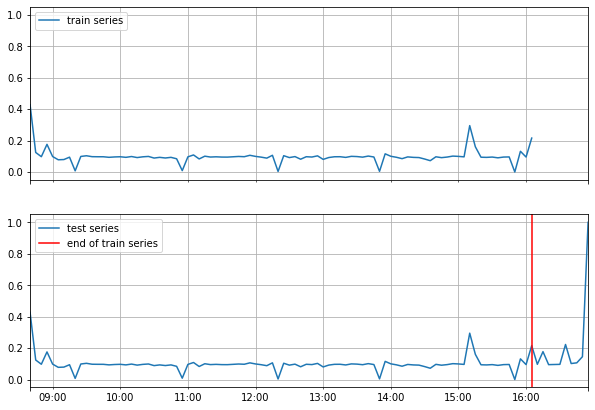

In [15]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

### SimpleFeedForwardEstimator

In [17]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx import Trainer

In [584]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=2*custom_ds_metadata['prediction_length'],
    freq=custom_ds_metadata['freq'],
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        learning_rate=1e-3, 
        hybridize=False, 
        num_batches_per_epoch=100,
        patience=3
    )
)
estimator

gluonts.model.simple_feedforward._estimator.SimpleFeedForwardEstimator(batch_normalization=False, batch_size=32, context_length=20, distr_output=gluonts.mx.distribution.student_t.StudentTOutput(), freq="5min", imputation_method=None, mean_scaling=True, num_hidden_dimensions=[10], num_parallel_samples=100, prediction_length=10, sampling=True, train_sampler=None, trainer=gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=10, hybridize=False, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=100, patience=3, weight_decay=1e-08), validation_sampler=None)

In [585]:
predictor = estimator.train(train_ds)

100%|██████████| 100/100 [00:01<00:00, 75.32it/s, epoch=10/10, avg_epoch_loss=-.205]


### custom network

In [564]:
from functools import partial
from mxnet.gluon import HybridBlock
from gluonts.core.component import validated
from gluonts.dataset.loader import TrainDataLoader
from gluonts.model.predictor import Predictor
from gluonts.mx import (
    as_in_context, 
    batchify,
    copy_parameters, 
    get_hybrid_forward_input_names,
    GluonEstimator,
    RepresentableBlockPredictor,
    Trainer,
)
from gluonts.transform import (
    ExpectedNumInstanceSampler,
    Transformation,
    InstanceSplitter,
    TestSplitSampler,
    SelectFields,
    Chain
)

In [565]:
class MyNetwork(gluon.HybridBlock):
    def __init__(self, prediction_length, num_cells, **kwargs):
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
        self.num_cells = num_cells
    
        with self.name_scope():
            # Set up a 3 layer neural network that directly predicts the target values
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=self.num_cells, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.num_cells, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length, activation='softrelu'))


class MyTrainNetwork(MyNetwork):    
    def hybrid_forward(self, F, past_target, future_target):
        prediction = self.nn(past_target)
        # calculate L1 loss with the future_target to learn the median
        return (prediction - future_target).abs().mean(axis=-1)


class MyPredNetwork(MyTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target):
        prediction = self.nn(past_target)
        return prediction.expand_dims(axis=1)
    
class MyEstimator(GluonEstimator):
    @validated()
    def __init__(
        self,
        prediction_length: int,
        context_length: int,
        freq: str,
        num_cells: int,
        batch_size: int = 32,
        trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer, batch_size=batch_size)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.freq = freq
        self.num_cells = num_cells
            
    def create_transformation(self):
        return Chain([])
    
    def create_training_data_loader(self, dataset, **kwargs):
        instance_splitter = InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=ExpectedNumInstanceSampler(
                num_instances=1,
                min_future=self.prediction_length
            ),
            past_length=self.context_length,
            future_length=self.prediction_length,
        )
        input_names = get_hybrid_forward_input_names(MyTrainNetwork)
        return TrainDataLoader(
            dataset=dataset,
            transform=instance_splitter + SelectFields(input_names),
            batch_size=self.batch_size,
            stack_fn=partial(batchify, ctx=self.trainer.ctx, dtype=self.dtype),
            decode_fn=partial(as_in_context, ctx=self.trainer.ctx),
            **kwargs,
        )
    
    def create_training_network(self) -> MyTrainNetwork:
        return MyTrainNetwork(
            prediction_length=self.prediction_length,
            num_cells = self.num_cells
        )

    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_splitter = InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=TestSplitSampler(),
            past_length=self.context_length,
            future_length=self.prediction_length,
        )

        prediction_network = MyPredNetwork(
            prediction_length=self.prediction_length,
            num_cells=self.num_cells
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation + prediction_splitter,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

In [566]:
predictor = estimator.train(train_ds)

100%|██████████| 100/100 [00:01<00:00, 80.72it/s, epoch=10/10, avg_epoch_loss=-.14]


### NBEATSEnsembleEstimator

In [567]:
from gluonts.model.n_beats import NBEATSEnsembleEstimator

estimator = NBEATSEnsembleEstimator(
#     num_hidden_dimensions=[10],
    prediction_length=custom_ds_metadata['prediction_length'],
#     context_length=2*custom_ds_metadata['prediction_length'],
    num_stacks=2,
    freq=custom_ds_metadata['freq'],
    trainer=Trainer(
        ctx="cpu", 
        epochs=10, 
        learning_rate=1e-3, 
        hybridize=False, 
#         num_batches_per_epoch=100,
        patience=3,
    )
)
estimator

TRAINER:gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=10, hybridize=False, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=3, weight_decay=1e-08)


gluonts.model.n_beats._ensemble.NBEATSEnsembleEstimator(expansion_coefficient_lengths=None, freq="5min", meta_bagging_size=10, meta_context_length=None, meta_loss_function=None, num_block_layers=None, num_blocks=None, num_stacks=2, prediction_length=10, sharing=None, stack_types=None, trainer=gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=10, hybridize=False, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=3, weight_decay=1e-08), widths=None)

In [ ]:
predictor = estimator.train(train_ds)

### NBEATSEstimator

In [569]:
from gluonts.model.n_beats import NBEATSEstimator

estimator = NBEATSEstimator(
#     num_hidden_dimensions=[10],
    prediction_length=custom_ds_metadata['prediction_length'],
#     context_length=2*custom_ds_metadata['prediction_length'],
#     num_stacks=2,
    freq=custom_ds_metadata['freq'],
    trainer=Trainer(
        ctx="cpu", 
        epochs=8, 
        learning_rate=1e-3, 
        hybridize=False, 
#         num_batches_per_epoch=100,
        patience=3,
    )
)
estimator

gluonts.model.n_beats._estimator.NBEATSEstimator(batch_size=32, context_length=None, expansion_coefficient_lengths=None, freq="5min", loss_function="MAPE", num_block_layers=None, num_blocks=None, num_stacks=30, prediction_length=10, scale=False, sharing=None, stack_types=None, train_sampler=None, trainer=gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=8, hybridize=False, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=3, weight_decay=1e-08), validation_sampler=None, widths=None)

In [570]:
predictor = estimator.train(train_ds)

100%|██████████| 50/50 [00:10<00:00,  4.62it/s, epoch=8/8, avg_epoch_loss=11.5]


### DeepStateEstimator TODO
The training is very slow! GPU is recommended.

In [622]:
from gluonts.model.deepstate import DeepStateEstimator

estimator = DeepStateEstimator(
#     num_hidden_dimensions=[10],
    prediction_length=custom_ds_metadata['prediction_length'],
#     context_length=2*custom_ds_metadata['prediction_length'],
#     num_stacks=2,
    freq=custom_ds_metadata['freq'],
    use_feat_static_cat=False,
    cardinality=[],
    trainer=Trainer(
        ctx="cpu", 
        epochs=8, 
        learning_rate=1e-3, 
        hybridize=False, 
#         num_batches_per_epoch=100,
        patience=3,
    )
)
estimator

gluonts.model.deepstate._estimator.DeepStateEstimator(add_trend=False, batch_size=32, cardinality=[], cell_type="lstm", dropout_rate=0.1, embedding_dimension=None, freq="5min", innovation_bounds=gluonts.mx.distribution.lds.ParameterBounds(lower=1e-06, upper=0.01), issm=None, noise_std_bounds=gluonts.mx.distribution.lds.ParameterBounds(lower=1e-06, upper=1.0), num_cells=40, num_layers=2, num_parallel_samples=100, num_periods_to_train=4, past_length=None, prediction_length=10, prior_cov_bounds=gluonts.mx.distribution.lds.ParameterBounds(lower=1e-06, upper=1.0), scaling=True, time_features=None, trainer=gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=8, hybridize=False, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=3, weight_decay=1e-08), use_feat_dynamic_real=False, use_feat_static_cat=False)

In [ ]:
predictor = estimator.train(train_ds)

### DeepFactorEstimator

In [628]:
from gluonts.model.deep_factor import DeepFactorEstimator

estimator = DeepFactorEstimator(
#     num_hidden_dimensions=[10],
    prediction_length=custom_ds_metadata['prediction_length'],
#     context_length=2*custom_ds_metadata['prediction_length'],
#     num_stacks=2,
    freq=custom_ds_metadata['freq'],
#     use_feat_static_cat=False,
#     cardinality=[],
    trainer=Trainer(
        ctx="cpu", 
        epochs=8, 
        learning_rate=1e-3, 
        hybridize=False, 
#         num_batches_per_epoch=100,
        patience=3,
    )
)
estimator

gluonts.model.deep_factor._estimator.DeepFactorEstimator(batch_size=32, cardinality=[1], cell_type="lstm", context_length=None, distr_output=gluonts.mx.distribution.student_t.StudentTOutput(), embedding_dimension=10, freq="5min", num_factors=10, num_hidden_global=50, num_hidden_local=5, num_layers_global=1, num_layers_local=1, num_parallel_samples=100, prediction_length=10, trainer=gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=8, hybridize=False, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=3, weight_decay=1e-08))

In [629]:
predictor = estimator.train(train_ds)

100%|██████████| 50/50 [00:00<00:00, 75.26it/s, epoch=8/8, avg_epoch_loss=-.374]


### DeepAREstimator

In [642]:
from gluonts.model.deepar import DeepAREstimator

estimator = DeepAREstimator(
#     num_hidden_dimensions=[10],
    prediction_length=custom_ds_metadata['prediction_length'],
#     context_length=2*custom_ds_metadata['prediction_length'],
#     num_stacks=2,
    freq=custom_ds_metadata['freq'],
#     use_feat_static_cat=False,
#     cardinality=[],
    trainer=Trainer(
        ctx="cpu", 
        epochs=8, 
        learning_rate=1e-3, 
        hybridize=False, 
#         num_batches_per_epoch=100,
        patience=3,
    )
)
estimator

gluonts.model.deepar._estimator.DeepAREstimator(alpha=0.0, batch_size=32, beta=0.0, cardinality=None, cell_type="lstm", context_length=None, default_scale=None, distr_output=gluonts.mx.distribution.student_t.StudentTOutput(), dropout_rate=0.1, dropoutcell_type="ZoneoutCell", embedding_dimension=None, freq="5min", imputation_method=None, impute_missing_values=False, lags_seq=None, minimum_scale=1e-10, num_cells=40, num_imputation_samples=1, num_layers=2, num_parallel_samples=100, prediction_length=10, scaling=True, time_features=None, train_sampler=None, trainer=gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=8, hybridize=False, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=3, weight_decay=1e-08), use_feat_dynamic_real=False, use_feat_static_cat=False, use_feat_static_real=False, validation_sam

In [643]:
predictor = estimator.train(train_ds)

100%|██████████| 50/50 [00:04<00:00, 11.22it/s, epoch=8/8, avg_epoch_loss=-.568]


### GaussianProcessEstimator

In [659]:
from gluonts.model.gp_forecaster import GaussianProcessEstimator

estimator = GaussianProcessEstimator(
#     num_hidden_dimensions=[10],
    prediction_length=custom_ds_metadata['prediction_length'],
#     context_length=2*custom_ds_metadata['prediction_length'],
#     num_stacks=2,
    freq=custom_ds_metadata['freq'],
#     use_feat_static_cat=False,
    cardinality=sample_num,
    trainer=Trainer(
        ctx="cpu", 
        epochs=8, 
        learning_rate=1e-3, 
        hybridize=False, 
#         num_batches_per_epoch=100,
        patience=3,
    )
)
estimator

gluonts.model.gp_forecaster._estimator.GaussianProcessEstimator(batch_size=32, cardinality=11, context_length=None, freq="5min", jitter_method="iter", kernel_output=gluonts.mx.kernels._rbf_kernel.RBFKernelOutput(), max_iter_jitter=10, num_parallel_samples=100, params_scaling=True, prediction_length=10, sample_noise=True, time_features=None, trainer=gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=8, hybridize=False, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=3, weight_decay=1e-08))

In [660]:
predictor = estimator.train(train_ds)

100%|██████████| 50/50 [00:00<00:00, 61.46it/s, epoch=8/8, avg_epoch_loss=927]


### GPVAREstimator TODO

In [685]:
from gluonts.model.gpvar import GPVAREstimator

estimator = GPVAREstimator(
    target_dim=1,
#     num_hidden_dimensions=[10],
    prediction_length=custom_ds_metadata['prediction_length'],
#     context_length=2*custom_ds_metadata['prediction_length'],
#     num_stacks=2,
    freq=custom_ds_metadata['freq'],
#     use_feat_static_cat=False,
#     cardinality=sample_num,
    trainer=Trainer(
        ctx="cpu", 
        epochs=8, 
        learning_rate=1e-3, 
        hybridize=False, 
#         num_batches_per_epoch=100,
        patience=3,
    )
)
estimator

gluonts.model.gpvar._estimator.GPVAREstimator(batch_size=32, cell_type="lstm", conditioning_length=100, context_length=None, distr_output=None, dropout_rate=0.1, freq="5min", lags_seq=None, num_cells=40, num_layers=2, num_parallel_samples=100, pick_incomplete=False, prediction_length=10, rank=2, scaling=True, shuffle_target_dim=True, target_dim=1, target_dim_sample=None, time_features=None, train_sampler=None, trainer=gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=8, hybridize=False, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=3, weight_decay=1e-08), use_marginal_transformation=False, validation_sampler=None)

In [686]:
predictor = estimator.train(train_ds)

GluonTSDataError: Input for field "target" does not have the requireddimension (field: target, ndim observed: 1, expected ndim: 2)

### MQCNNEstimator

In [696]:
from gluonts.model.seq2seq import MQCNNEstimator

estimator = MQCNNEstimator(
#     target_dim=1,
#     num_hidden_dimensions=[10],
    prediction_length=custom_ds_metadata['prediction_length'],
#     context_length=2*custom_ds_metadata['prediction_length'],
#     num_stacks=2,
    freq=custom_ds_metadata['freq'],
#     use_feat_static_cat=False,
#     cardinality=sample_num,
    trainer=Trainer(
        ctx="cpu", 
        epochs=15, 
        learning_rate=1e-3, 
        hybridize=False, 
#         num_batches_per_epoch=100,
        patience=3,
    )
)
estimator

gluonts.model.seq2seq._mq_dnn_estimator.MQCNNEstimator(add_age_feature=False, add_time_feature=True, cardinality=None, channels_seq=None, context_length=None, decoder_mlp_dim_seq=None, dilation_seq=None, distr_output=None, embedding_dimension=None, enable_decoder_dynamic_feature=True, enable_encoder_dynamic_feature=True, freq="5min", kernel_size_seq=None, max_ts_len=None, num_forking=None, prediction_length=10, quantiles=None, scaling=None, scaling_decoder_dynamic_feature=False, seed=None, trainer=gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=15, hybridize=False, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=3, weight_decay=1e-08), use_feat_dynamic_real=False, use_feat_static_cat=False, use_past_feat_dynamic_real=False, use_residual=True)

In [697]:
predictor = estimator.train(train_ds)

100%|██████████| 50/50 [00:01<00:00, 34.84it/s, epoch=15/15, avg_epoch_loss=0.00864]


### TemporalFusionTransformerEstimator

In [19]:
from gluonts.model.tft import TemporalFusionTransformerEstimator

estimator = TemporalFusionTransformerEstimator(
#     target_dim=1,
#     num_hidden_dimensions=[10],
    prediction_length=custom_ds_metadata['prediction_length'],
#     context_length=2*custom_ds_metadata['prediction_length'],
#     num_stacks=2,
    freq=custom_ds_metadata['freq'],
#     use_feat_static_cat=False,
#     cardinality=sample_num,
    trainer=Trainer(
        ctx="cpu", 
        epochs=15, 
        learning_rate=1e-3, 
        hybridize=False, 
#         num_batches_per_epoch=100,
        patience=3,
    )
)
estimator

gluonts.model.tft._estimator.TemporalFusionTransformerEstimator(batch_size=32, context_length=None, dropout_rate=0.1, dynamic_cardinalities={}, dynamic_feature_dims={}, freq="5min", hidden_dim=32, num_heads=4, num_instance_per_series=100, num_outputs=3, past_dynamic_features=[], prediction_length=10, static_cardinalities={}, static_feature_dims={}, time_features=[], train_sampler=None, trainer=gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=15, hybridize=False, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=3, weight_decay=1e-08), validation_sampler=None, variable_dim=None)

In [802]:
predictor = estimator.train(train_ds)

100%|██████████| 50/50 [00:05<00:00,  8.78it/s, epoch=15/15, avg_epoch_loss=0.0311]


### TransformerEstimator

In [725]:
from gluonts.model.transformer import TransformerEstimator

estimator = TransformerEstimator(
#     target_dim=1,
#     num_hidden_dimensions=[10],
    prediction_length=custom_ds_metadata['prediction_length'],
#     context_length=2*custom_ds_metadata['prediction_length'],
#     num_stacks=2,
    freq=custom_ds_metadata['freq'],
#     use_feat_static_cat=False,
#     cardinality=sample_num,
    trainer=Trainer(
        ctx="cpu", 
        epochs=15, 
        learning_rate=1e-3, 
        hybridize=False, 
#         num_batches_per_epoch=100,
        patience=3,
    )
)
estimator

gluonts.model.transformer._estimator.TransformerEstimator(act_type="softrelu", batch_size=32, cardinality=None, context_length=None, distr_output=gluonts.mx.distribution.student_t.StudentTOutput(), dropout_rate=0.1, embedding_dimension=20, freq="5min", inner_ff_dim_scale=4, lags_seq=None, model_dim=32, num_heads=8, num_parallel_samples=100, post_seq="drn", pre_seq="dn", prediction_length=10, scaling=True, time_features=None, train_sampler=None, trainer=gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=15, hybridize=False, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=3, weight_decay=1e-08), use_feat_dynamic_real=False, use_feat_static_cat=False, validation_sampler=None)

In [726]:
predictor = estimator.train(train_ds)

100%|██████████| 50/50 [00:01<00:00, 26.51it/s, epoch=15/15, avg_epoch_loss=-.624]


### WaveNet

In [740]:
from gluonts.model.wavenet import WaveNetEstimator

estimator = WaveNetEstimator(
#     target_dim=1,
#     num_hidden_dimensions=[10],
    prediction_length=custom_ds_metadata['prediction_length'],
#     context_length=2*custom_ds_metadata['prediction_length'],
#     num_stacks=2,
    freq=custom_ds_metadata['freq'],
#     use_feat_static_cat=False,
#     cardinality=sample_num,
    trainer=Trainer(
        ctx="cpu", 
        epochs=15, 
        learning_rate=1e-3, 
        hybridize=False, 
#         num_batches_per_epoch=100,
        patience=3,
    )
)
estimator

gluonts.model.wavenet._estimator.WaveNetEstimator(act_type="elu", batch_size=32, cardinality=[1], dilation_depth=None, embedding_dimension=5, freq="5min", hybridize_prediction_net=False, n_residue=24, n_skip=32, n_stacks=1, negative_data=False, num_bins=1024, num_parallel_samples=200, prediction_length=10, seasonality=None, temperature=1.0, train_sampler=None, train_window_length=None, trainer=gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=15, hybridize=False, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=3, weight_decay=1e-08), validation_sampler=None)

In [741]:
predictor = estimator.train(train_ds)

100%|██████████| 50/50 [00:01<00:00, 27.90it/s, epoch=15/15, avg_epoch_loss=4.05]


### multivariate model data preprocessing

In [608]:
prediction_length = 5

feature_num_max = len(sample_lists[0]) # the first element is the start_time.
feature_num = 1

train_ds = ListDataset(
    [
        {
            FieldName.TARGET: [s[:-custom_ds_metadata['prediction_length']] for s in sample],
            FieldName.START: start_time,
            FieldName.FEAT_DYNAMIC_REAL: [s[:-custom_ds_metadata['prediction_length']] for s in sample], #[fdr],
#             FieldName.FEAT_STATIC_CAT: [fsc],
        }
        for start_time, sample in zip(start_times, sample_lists)
#         for (target, start, fdr, fsc) in zip(
#             target[:, :-custom_ds_metadata['prediction_length']],
#             custom_ds_metadata['start'],
#             feat_dynamic_real[:, :-custom_ds_metadata['prediction_length']],
#             feat_static_cat
#         )
    ],
    freq=custom_ds_metadata['freq']
)

test_ds = ListDataset(
    [
        {
            FieldName.TARGET: sample,
            FieldName.START: start_time,
            FieldName.FEAT_DYNAMIC_REAL: sample, #[fdr],
#             FieldName.FEAT_STATIC_CAT: [fsc],
        }
        for start_time, sample in zip(start_times, sample_lists)
#         for (target, start, fdr, fsc) in zip(
#             target[:, :-custom_ds_metadata['prediction_length']],
#             custom_ds_metadata['start'],
#             feat_dynamic_real[:, :-custom_ds_metadata['prediction_length']],
#             feat_static_cat
#         )
    ],
    freq=custom_ds_metadata['freq']
)

In [609]:
ss = sample_lists[1:]
len(ss), [len(s) for s in ss], len(ss[0][1])


(10, [40, 40, 40, 40, 40, 40, 40, 40, 40, 40], 100)

In [511]:
# artificial data (from https://github.com/mbohlkeschneider/gluon-ts/blob/mv_release/src/gluonts/multivariate/datasets/sinus_covariance.py#L20)

max_target_dim = 5
rank: int = 2
    
freq = "1H"
start = pd.Timestamp("1800-01-01", freq)
prediction_length: int = 24
num_freq = 1000
num_obs_per_freq = prediction_length
num_observations = num_freq * num_obs_per_freq
tt = np.arange(0, num_observations) * (2 * np.pi) / num_obs_per_freq
pho_t = np.sin(tt)

U = np.random.uniform(size=(max_target_dim, rank)) - 0.5

sigma_0 = 0.1

def get_Sigma(pho):
    if rank == 2:
        S = np.array(
            [
                [sigma_0 ** 2, sigma_0 ** 2 * pho],
                [sigma_0 ** 2 * pho, sigma_0 ** 2],
            ]
        )
    if rank == 1:
        S = np.array(pho + 1 + sigma_0)
    # return np.dot(S, S)
    # return S
    return np.dot(np.dot(U, S), U.T)

mu = pho_t.reshape((-1, 1)).dot(np.ones((1, max_target_dim)))

Sigma_true = np.stack([get_Sigma(pho_t[i]) for i in range(len(tt))])
Sigma_true /= Sigma_true.std()

# for k in range(0, target_dim):
#     plt.plot(Sigma_true[:100, 0, k], label=k)
# plt.legend()
# plt.show()

values = np.stack(
    [
        np.random.multivariate_normal(mu[t], Sigma_true[t])
        for t in range(len(tt))
    ]
)

# for j in range(0, values.shape[0]):
#    plt.plot(values[j, :72])
# plt.tight_layout()
# plt.savefig("artificial-timeseries.pdf")

# values = np.hstack([values, pho_t.reshape((-1, 1))])

values = values.transpose()

target_dim = values.shape[0]

train_ds = [
    {'item': '0', 'start': start, 'target': values[:, :-prediction_length]}
]

test_ds = [{'item': '0', 'start': start, 'target': values}]

values

array([[ 0.24926796,  0.07956791,  1.27267834, ...,  0.25300533,
        -0.42542594,  1.45721259],
       [ 1.45131571, -0.17237089,  2.65355383, ..., -0.50802066,
        -0.64057716,  2.02216827],
       [ 0.41520698,  0.12413502,  1.15947489, ..., -0.55046754,
        -0.52958985,  0.53631667],
       [ 0.09873335,  0.18220053,  0.8275661 , ..., -0.27735968,
        -0.46518917,  0.49161831],
       [-0.22388685,  0.24186622,  0.48740202, ..., -0.0031057 ,
        -0.39998105,  0.44010465]])

### LSTNetEstimator TODO

In [606]:
from gluonts.model.lstnet import LSTNetEstimator

estimator = LSTNetEstimator(
#     num_hidden_dimensions=[10],
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=2*custom_ds_metadata['prediction_length'],
#     num_stacks=2,
    freq=custom_ds_metadata['freq'],
    num_series=len(samples[0])-2, # minus start_time, sample[0] (target)
    skip_size=2,
    ar_window=3,
    channels=2,
    trainer=Trainer(
        ctx="cpu", 
        epochs=8, 
            learning_rate=1e-3, 
        
#         num_batches_per_epoch=100,
        patience=3,
    )
)
estimator

gluonts.model.lstnet._estimator.LSTNetEstimator(ar_window=3, batch_size=32, channels=2, context_length=20, dropout_rate=0.2, freq="5min", kernel_size=6, lead_time=0, num_series=98, output_activation=None, prediction_length=10, rnn_cell_type="gru", rnn_num_cells=100, rnn_num_layers=3, scaling=True, skip_rnn_cell_type="gru", skip_rnn_num_cells=10, skip_rnn_num_layers=1, skip_size=2, train_sampler=None, trainer=gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=8, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=3, weight_decay=1e-08), validation_sampler=None)

In [610]:
predictor = estimator.train(train_ds)

GluonTSDataError: Array 'target' has bad shape - expected 1 dimensions, got 2.

### DeepVAREstimator TODO

In [616]:
from gluonts.model.deepvar import DeepVAREstimator

estimator = DeepVAREstimator(
    target_dim=2,
#     num_hidden_dimensions=[10],
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=2*custom_ds_metadata['prediction_length'],
#     num_stacks=2,
    freq=custom_ds_metadata['freq'],
#     num_series=len(samples[0])-2, # minus start_time, sample[0] (target)
#     skip_size=2,
#     ar_window=3,
#     channels=2,
    trainer=Trainer(
        ctx="cpu", 
        epochs=8, 
            learning_rate=1e-3, 
        
#         num_batches_per_epoch=100,
        patience=3,
    )
)
estimator

gluonts.model.deepvar._estimator.DeepVAREstimator(batch_size=32, cardinality=[1], cell_type="lstm", conditioning_length=200, context_length=20, distr_output=None, dropout_rate=0.1, embedding_dimension=5, freq="5min", lags_seq=None, num_cells=40, num_layers=2, num_parallel_samples=100, pick_incomplete=False, prediction_length=10, rank=5, scaling=True, target_dim=2, time_features=None, train_sampler=None, trainer=gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=8, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=3, weight_decay=1e-08), use_marginal_transformation=False, validation_sampler=None)

In [617]:
predictor = estimator.train(train_ds)

GluonTSDataError: Array 'target' has bad shape - expected 1 dimensions, got 2.

### evaluation prediction

In [742]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [743]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [744]:
# first entry of the time series list
ts_entry = tss[0]
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([0.42734018, 0.12412893, 0.09729007, 0.17565951, 0.09822436],
      dtype=float32)

In [745]:
# first entry of test_ds
test_ds_entry = next(iter(test_ds))
# first 5 values
test_ds_entry['target'][:5]

array([0.42734018, 0.12412893, 0.09729007, 0.17565951, 0.09822436],
      dtype=float32)

In [746]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [747]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 10)
Start date of the forecast window: 2021-03-04 16:10:00
Frequency of the time series: 5min


In [748]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [0.12856208 0.12978704 0.12304476 0.1151671  0.1054271  0.11487828
 0.11396206 0.10304685 0.11058592 0.11452974]
0.5-quantile (median) of the future window:
 [0.1314602  0.12946838 0.12946838 0.12249701 0.1215011  0.12648065
 0.12747656 0.11950927 0.12448884 0.12050518]


In [749]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

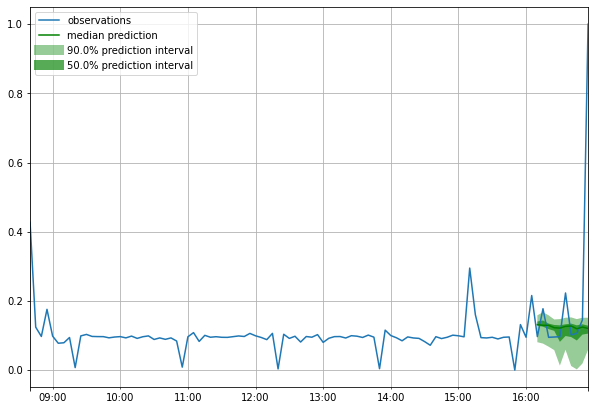

In [750]:
plot_prob_forecasts(ts_entry, forecast_entry)

### Evaluation

In [751]:
from gluonts.evaluation import Evaluator

In [752]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 11/11 [00:01<00:00,  5.82it/s]


In [753]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.04343912959183482,
    "abs_error": 12.990894079208374,
    "abs_target_sum": 78.85642957687378,
    "abs_target_mean": 0.7168766325170344,
    "seasonal_error": 0.16266599130094722,
    "MASE": 1.0628527580809044,
    "MAPE": 0.6448213427957862,
    "sMAPE": 0.20759024024009703,
    "MSIS": 19.436955213587,
    "QuantileLoss[0.1]": 10.303256207704544,
    "Coverage[0.1]": 0.1,
    "QuantileLoss[0.5]": 12.990894213318825,
    "Coverage[0.5]": 0.7000000000000001,
    "QuantileLoss[0.9]": 6.659830720722676,
    "Coverage[0.9]": 0.8636363636363636,
    "RMSE": 0.20842055942693086,
    "NRMSE": 0.29073420721657905,
    "ND": 0.16474108895006595,
    "wQuantileLoss[0.1]": 0.13065841635221814,
    "wQuantileLoss[0.5]": 0.16474109065075734,
    "wQuantileLoss[0.9]": 0.08445513899700835,
    "mean_absolute_QuantileLoss": 9.984660380582014,
    "mean_wQuantileLoss": 0.12661821533332793,
    "MAE_Coverage": 0.07878787878787881,
    "OWA": NaN
}


### Evaluate and compare models

In [775]:
custom_ds_metadata = {
    'num_series': len(sample_lists),
    'num_steps': len(sample_lists[0][0]),
    'prediction_length': 10,
    'freq': '5min',
    'start': start_times
}

print(f'{custom_ds_metadata =}')

feature_num = 1

feature_num_max = len(sample_lists[0]) # the first element is the start_time.
sample_num = len(sample_lists)
train_proportion = 0.8
train_size = int(sample_num*train_proportion)

var_num = len(sample_lists[0])

train_ds = ListDataset(
    [
        {
            FieldName.TARGET: sample[feature_num][:-custom_ds_metadata['prediction_length']],
            FieldName.START: start_time,
            FieldName.FEAT_DYNAMIC_REAL: [s[:-custom_ds_metadata['prediction_length']] for s in sample], #[fdr],
        }
        for start_time, sample in zip(start_times[:train_size], sample_lists[:train_size])
    ],
    freq=custom_ds_metadata['freq']
)

test_ds = ListDataset(
    [
        {
            FieldName.TARGET: sample[feature_num],
            FieldName.START: start_time,
            FieldName.FEAT_DYNAMIC_REAL: sample, #[fdr],
        }
        for start_time, sample in zip(start_times[train_size:], sample_lists[train_size:])
    ],
    freq=custom_ds_metadata['freq']
)

custom_ds_metadata ={'num_series': 11, 'num_steps': 100, 'prediction_length': 10, 'freq': '5min', 'start': ['2021-03-04 08:40:00', '2021-03-05 10:35:00', '2021-03-08 08:45:00', '2021-03-09 08:35:00', '2021-03-10 08:55:00', '2021-03-17 09:45:00', '2021-03-18 08:20:00', '2021-03-19 08:20:00', '2021-03-22 09:15:00', '2021-03-25 08:40:00', '2021-03-31 09:05:00']}


In [803]:
def evaluate_models(estimatiors, train_ds, test_ds):
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    res = {}
    for estimator_name, estimator in estimatiors.items():
        print(f'\nTrain {estimator_name}')
        predictor = estimator.train(train_ds)
        forecast_it, ts_it = make_evaluation_predictions(
            dataset=test_ds,  
            predictor=predictor,  
            num_samples=sample_num,  
        )
        forecasts = list(forecast_it)
        tss = list(ts_it)
        agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
        res[estimator_name] = agg_metrics        
    return res

trainer = Trainer(
            ctx="cpu", 
            epochs=20, 
            learning_rate=1e-3, 
            hybridize=False, 
#             num_batches_per_epoch=100,
            patience=5,
            minimum_learning_rate=5e-07,
        )

estimatiors = {
    'SimpleFeedForwardEstimator': SimpleFeedForwardEstimator(
        prediction_length=custom_ds_metadata['prediction_length'],
        freq=custom_ds_metadata['freq'],
        trainer=trainer,
        num_hidden_dimensions=[10],
        context_length=2*custom_ds_metadata['prediction_length'],
        ),
    'NBEATSEstimator': NBEATSEstimator(
        prediction_length=custom_ds_metadata['prediction_length'],
        freq=custom_ds_metadata['freq'],
        trainer=trainer,
    ),""
#     'NBEATSEnsembleEstimator': NBEATSEnsembleEstimator(
#     #     num_hidden_dimensions=[10],
#         prediction_length=custom_ds_metadata['prediction_length'],
#     #     context_length=2*custom_ds_metadata['prediction_length'],
#         num_stacks=2,
#         freq=custom_ds_metadata['freq'],
#         trainer=trainer
#     ),
    'DeepFactorEstimator': DeepFactorEstimator(
            prediction_length=custom_ds_metadata['prediction_length'],
            freq=custom_ds_metadata['freq'],
            trainer=trainer,
        ),
    'DeepAREstimator': DeepAREstimator(
            prediction_length=custom_ds_metadata['prediction_length'],
            freq=custom_ds_metadata['freq'],
            trainer=trainer,
        ),
    'GaussianProcessEstimator': GaussianProcessEstimator(
            prediction_length=custom_ds_metadata['prediction_length'],
            freq=custom_ds_metadata['freq'],
            trainer=trainer,
            cardinality=sample_num,
        ),
    'MQCNNEstimator': MQCNNEstimator(
            prediction_length=custom_ds_metadata['prediction_length'],
            freq=custom_ds_metadata['freq'],
            trainer=trainer,
        ),
    'TemporalFusionTransformerEstimator': TemporalFusionTransformerEstimator(
            prediction_length=custom_ds_metadata['prediction_length'],
            freq=custom_ds_metadata['freq'],
            trainer=trainer,
        ),
    'TransformerEstimator': TransformerEstimator(
            prediction_length=custom_ds_metadata['prediction_length'],
            freq=custom_ds_metadata['freq'],
            trainer=trainer,
        ),
    'WaveNetEstimator': WaveNetEstimator(
            prediction_length=custom_ds_metadata['prediction_length'],
            freq=custom_ds_metadata['freq'],
            trainer=trainer,
        ),
}

results = evaluate_models(estimatiors, train_ds, test_ds)

  0%|          | 0/50 [00:00<?, ?it/s]


Train SimpleFeedForwardEstimator


  0%|          | 0/50 [00:00<?, ?it/s]


Train NBEATSEstimator


  0%|          | 0/50 [00:00<?, ?it/s]


Train DeepFactorEstimator


  0%|          | 0/50 [00:00<?, ?it/s]


Train DeepAREstimator


Running evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Early stopping based on learning rate scheduler callback (min_lr was reached).


  0%|          | 0/50 [00:00<?, ?it/s]


Train GaussianProcessEstimator


Running evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Early stopping based on learning rate scheduler callback (min_lr was reached).


  0%|          | 0/50 [00:00<?, ?it/s]


Train MQCNNEstimator


Running evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Early stopping based on learning rate scheduler callback (min_lr was reached).


  0%|          | 0/50 [00:00<?, ?it/s]


Train TemporalFusionTransformerEstimator


100%|██████████| 50/50 [00:05<00:00,  9.58it/s, epoch=1/20, avg_epoch_loss=0.0403]


Early stopping based on learning rate scheduler callback (min_lr was reached).


  0%|          | 0/50 [00:00<?, ?it/s]


Train TransformerEstimator


Running evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Early stopping based on learning rate scheduler callback (min_lr was reached).


  0%|          | 0/50 [00:00<?, ?it/s]


Train WaveNetEstimator


Running evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Early stopping based on learning rate scheduler callback (min_lr was reached).


Running evaluation: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


In [807]:
import json
json.dump(results, open('../data/results.json', 'w'))

In [804]:
def select_best(results):    
    return pd.DataFrame(results.values(), index=results.keys()).idxmin()

select_best(results)

MSE                           TemporalFusionTransformerEstimator
abs_error                     TemporalFusionTransformerEstimator
abs_target_sum                        SimpleFeedForwardEstimator
abs_target_mean                       SimpleFeedForwardEstimator
seasonal_error                        SimpleFeedForwardEstimator
MASE                          TemporalFusionTransformerEstimator
MAPE                          TemporalFusionTransformerEstimator
sMAPE                         TemporalFusionTransformerEstimator
MSIS                                  SimpleFeedForwardEstimator
QuantileLoss[0.1]                                DeepAREstimator
Coverage[0.1]                           GaussianProcessEstimator
QuantileLoss[0.5]             TemporalFusionTransformerEstimator
Coverage[0.5]                                    NBEATSEstimator
QuantileLoss[0.9]             TemporalFusionTransformerEstimator
Coverage[0.9]                                    NBEATSEstimator
RMSE                     

### Conclusions
- The `TemporalFusionTransformer` NN is the best NN for the current data distribution.


### Further Improvements
- Consolidate `target` from several variables
- Concatenate `source` from all logs
- Add categorial variables to `source`
- Tune up hyperparameters for the model


# Workflow: Data preprocessing, training, detection

In [ ]:
# pseudocode:

for log in logs:
    # data preprocessing
    remove unused fields
    convert dt to timestamp format
    adjust to 5 min buckets
    select numerical fields
    aggregate numerical fields to 1 record per bucket []
    aggregate features into the y feature per bucket
    
    convert format to time series samples: sample:: start_time, features * readings

select logs with enough samples
combined log: concatenate logs by time buckets

# model:
    train:
        convert combined log into ListDataset
        train with combined ListDataset
        save model

    detect:
        detect with combined log
        select anomalies with threshold
        unwind address fields from the original logs
        format alerts with anomalies + address fields
        send alerts


In [26]:
data_dir = '../data'
logs = ['dns', 'flows', 'l7']

dt_field = 'start_time' # each log should have it!
measurements = {
    'dns':
    [
        ('count', None), ('latency_count', None), ('latency_mean', None),
        ('latency_max', None), 
    ],
    'flows':
    [
        ('bytes_in', None), ('bytes_out', None), 
        ('num_flows', None), ('num_flows_started', None),  ('num_flows_completed', None), 
        ('packets_in', None), ('packets_out', None), 
        ('http_requests_allowed_in', ['count']), ('http_requests_denied_in', ['count']), 
        ('num_process_names', ['count']), ('num_process_ids', ['count']), ('num_original_source_ips', ['count']), 
    ],
    'l7':
    [
        ('count', None), ('duration_mean', None), ('duration_max', None), 
        ('bytes_in', None), ('bytes_out', None), 
    
    ],
}
agg_funcs = ['count', 'sum', 'mean', 'std', 'max']


single_sample_minutes = 5
freq = f'{single_sample_minutes}min'
forecasting_minutes = 30
training_sample_reading_num = 120 # train + forecasting horizon
forecasting_horizon = training_sample_reading_num - int(forecasting_minutes/single_sample_minutes) # 114
# trainig can start only if logs have initial_training_sample_reading_num readings, means at last 18 * 5 = 1.5 hours of the cluster work.
initial_training_sample_reading_num = 18 # train + forecasting horizon
initial_forecasting_horizon = initial_training_sample_reading_num - int(forecasting_minutes/single_sample_minutes) # 12

In [27]:
def read_log(file):
    file_path = f'{data_dir}/{file}'
    log = file.split('.')[2]
    print(f'Read "{file}"')
    return log, pd.read_csv(file_path)

def preprocess_table_data(logs: dict):
    for log, df in logs.items():        
        #     remove unused fields
        # get used fields:
        used_fields = [field for field, _ in measurements]
        print(used_fields)
        #     convert dt to timestamp format
        #     adjust to 5 min buckets
        #     select numerical fields
        #     aggregate numerical fields to 1 record per bucket []
        #     aggregate features into the y feature per bucket


logs = dict([read_log(file) for file in ['20210722_172941.cluster.dns.115K.csv', '20210722_172919.cluster.l7.10K.csv', '20210722_172916.cluster.flows.40K.csv']])
l

Read "20210722_172941.cluster.dns.115K.csv"
Read "20210722_172919.cluster.l7.10K.csv"
Read "20210722_172916.cluster.flows.40K.csv"


/home/leonid/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3427: DtypeWarning: Columns (2,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


dict_keys(['dns', 'l7', 'flows'])